In [1]:
# from utils.Auger.SD.Monitoring import Monit
from scipy.optimize import curve_fit
from utils.binaries import *
from utils import CONSTANTS
from utils.plotting import *
import os

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, t=None, version=None):
     
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC_bin_edges = np.array([4*k for k in range(100)] + [400 + 16*k for k in range(51)])
        case 3:
            ADC_bin_edges = np.array([2*k for k in range(100)] + [200 + 8*k for k in range(51)])
    ADC = 0.5 * (ADC_bin_edges[1:] + ADC_bin_edges[:-1])

    skip = 5
    _peak = np.argmax(counts[skip:100]) + skip
    _dip = np.argmax(np.diff(counts)) + 3
    start, stop = _dip + int(0.5 * (_peak - _dip)), _peak + int(0.5*(_peak - _dip))

    try:
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop],
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, ADC[_peak], counts[_peak]])
        
        dir = f'/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/'
        if not os.path.isfile(f"{dir}/{int(t)}.png"):
            os.makedirs(dir, exist_ok=True)
            _ = plt.figure()
            plt.plot(ADC, counts)
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height))
            plt.save(f"{dir}/{int(t)}.png")
            plt.close(_)

        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError
        if mip.n > 300: raise ValueError

    except: 
        return np.nan, np.nan

    return mip.n, mip.std_dev


10:47:24 (+14710.1s) [INFO   ] -- import logging
10:47:24 (    +2ms) [INFO   ] -- import numpy as np
10:47:24 (    +7ms) [INFO   ] -- import uncertainties
10:47:24 (    +2ms) [INFO   ] -- import numpy as np
10:47:24 (    +7ms) [INFO   ] -- import uncertainties
10:47:24 (  +223ms) [INFO   ] -- import pandas as pd
10:47:24 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
10:47:24 (    +1ms) [INFO   ] -- import binaries.tools as tools
10:47:25 (  +310ms) [INFO   ] -- import matplotlib.pyplot as plt
10:47:25 (  +192ms) [INFO   ] -- import seaborn as so
10:47:25 (    +2ms) [INFO   ] -- import plotting.tools as plot
10:47:25 (    +7ms) [DEBUG  ] -- font size set to 9.5
10:47:25 (    +1ms) [DEBUG  ] -- label size set to 13.0
10:47:25 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
10:47:25 (    +1ms) [DEBUG  ] -- markersize set to 2.0
10:47:25 (    +1ms) [DEBUG  ] -- usetex set to False


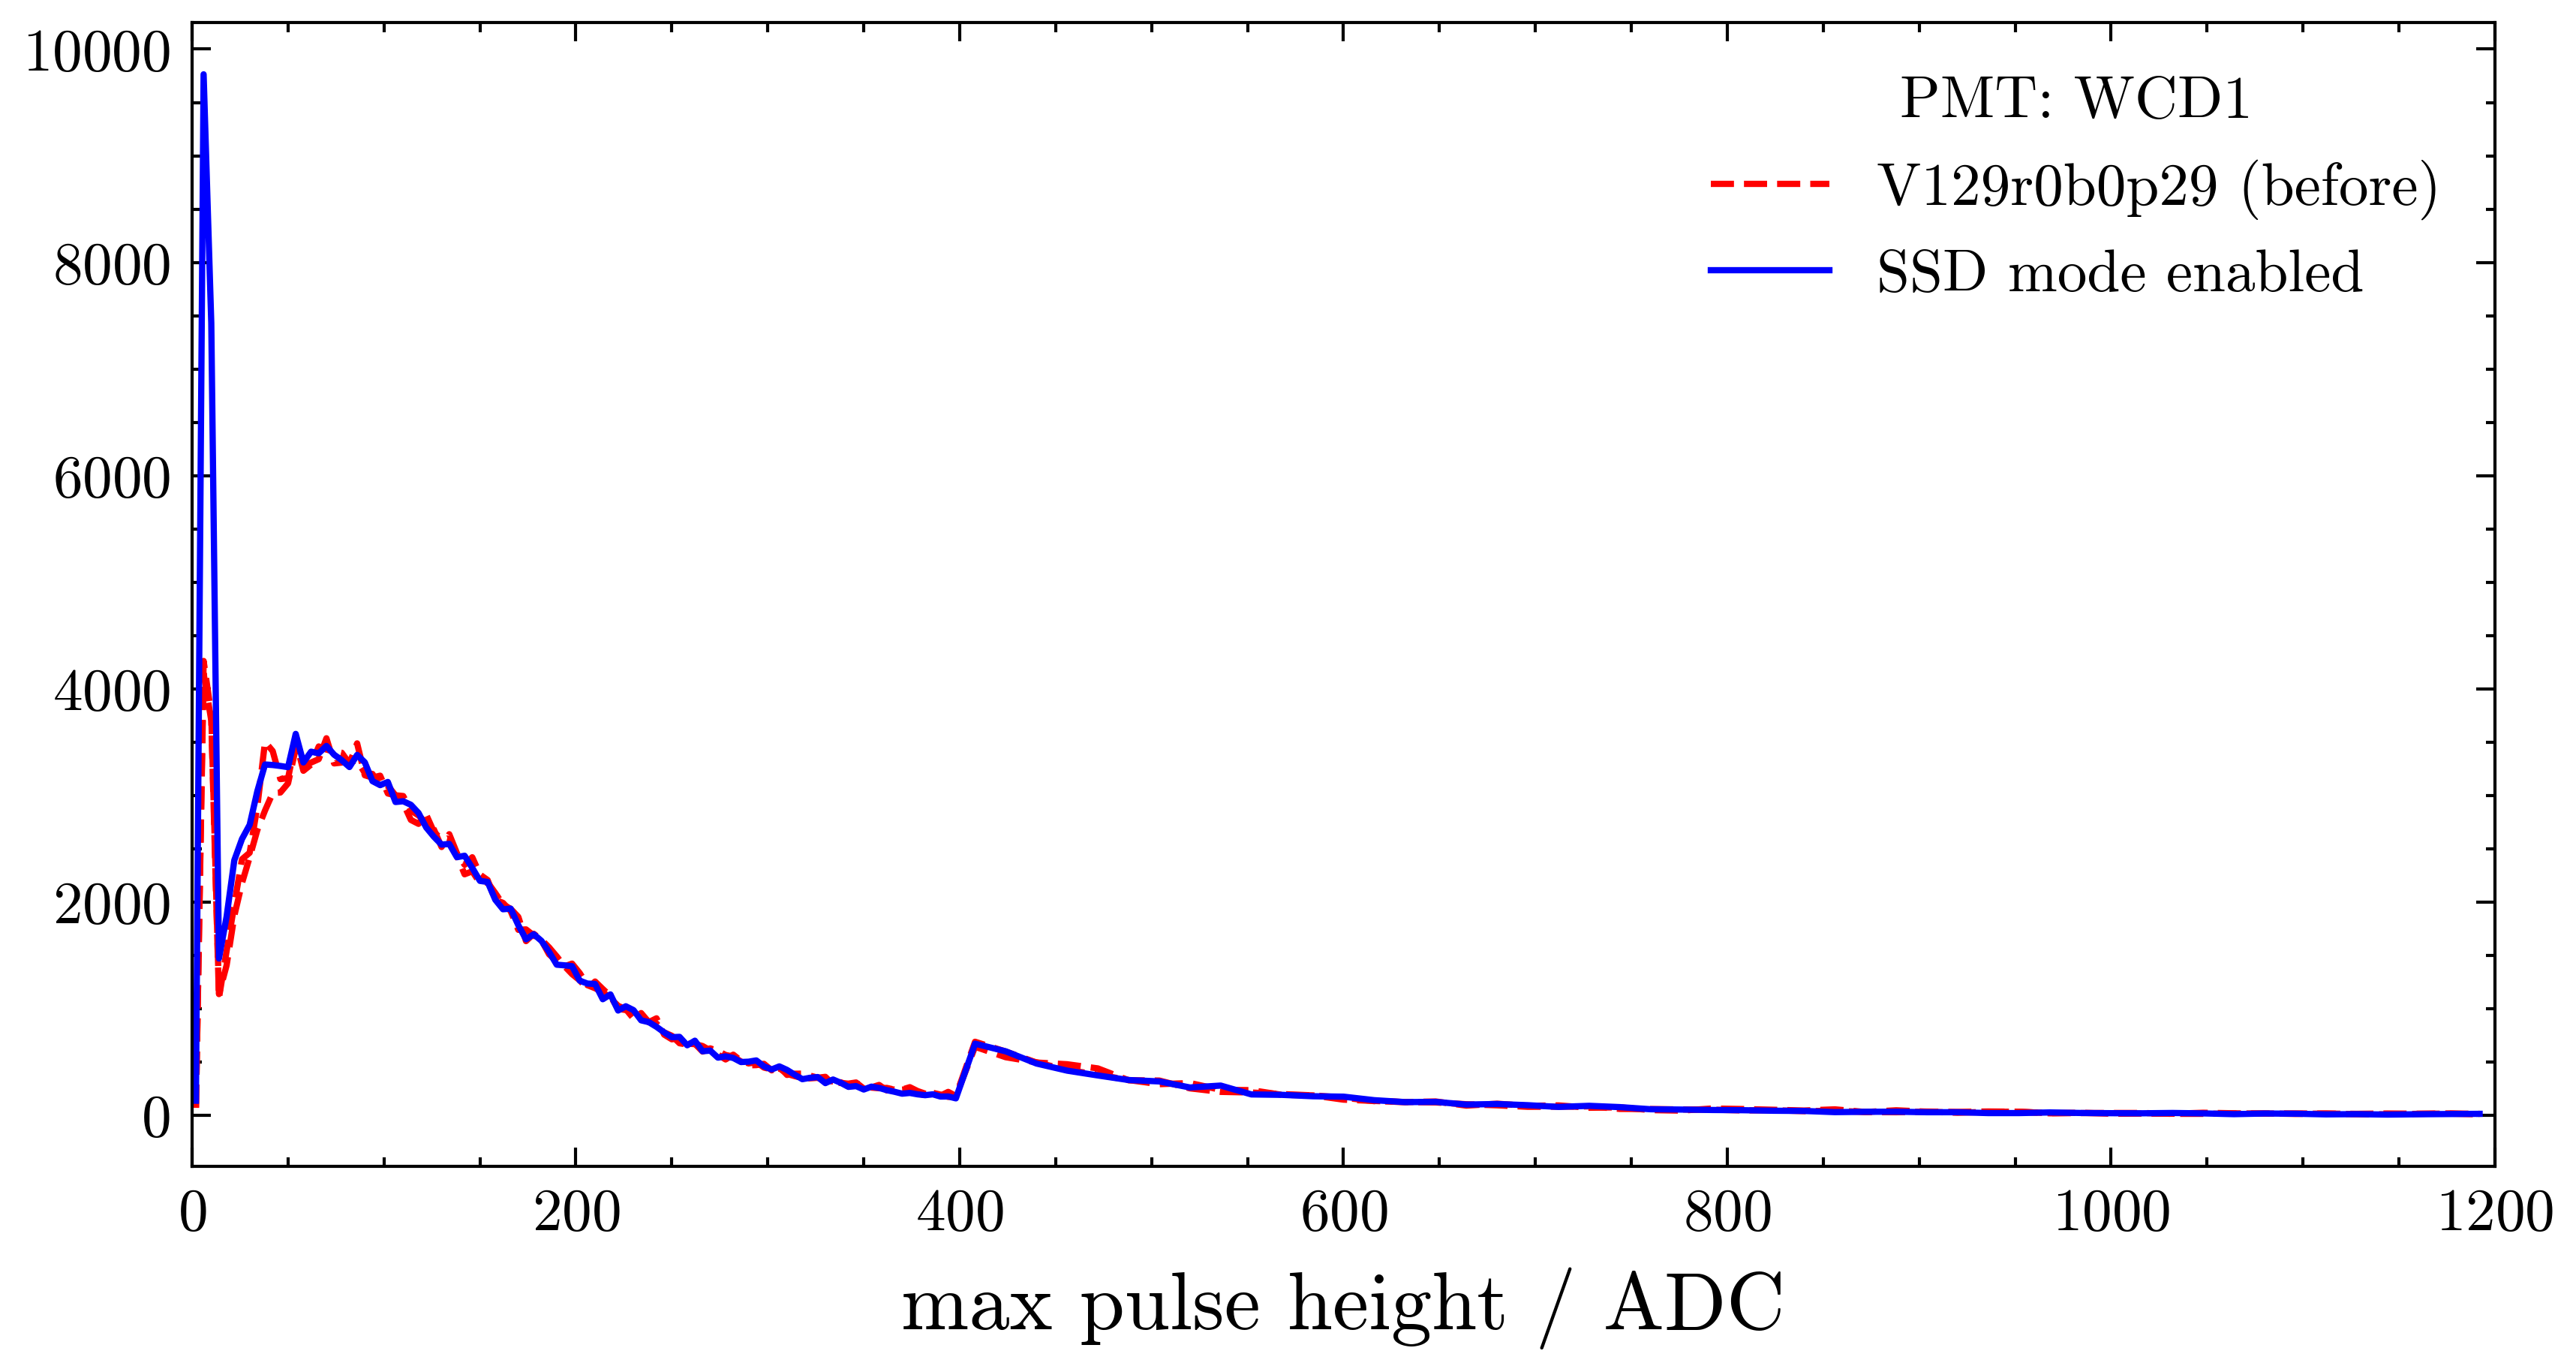

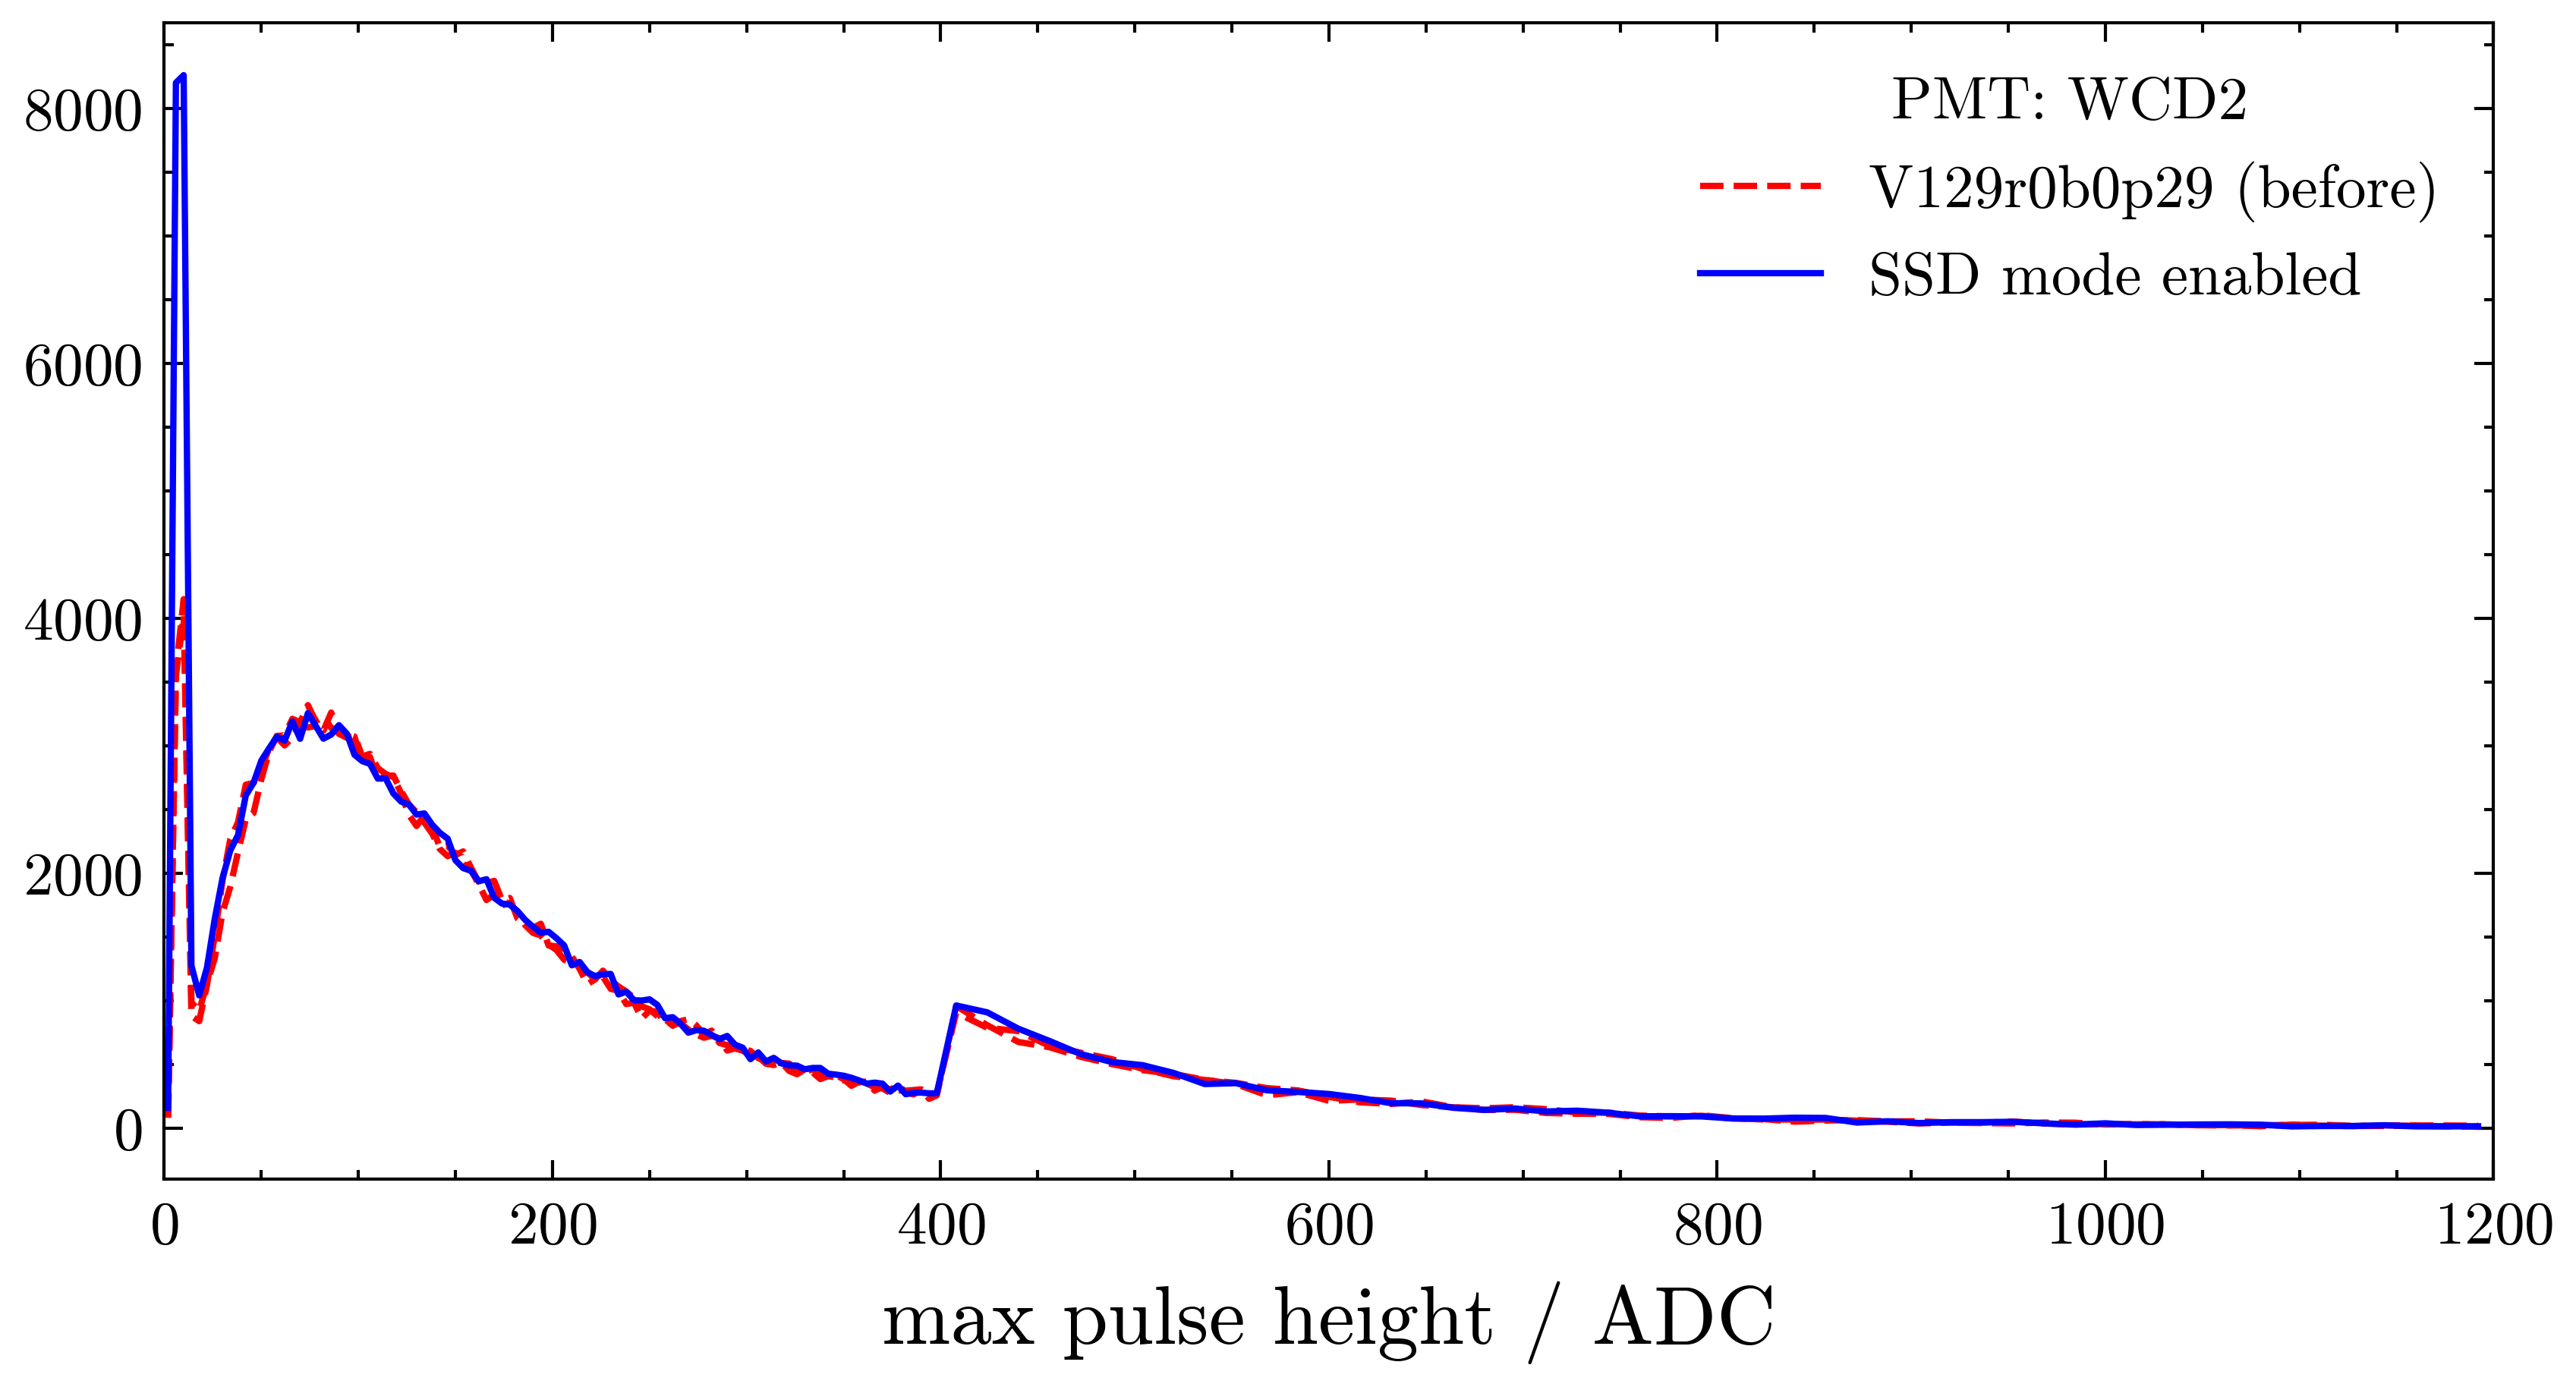

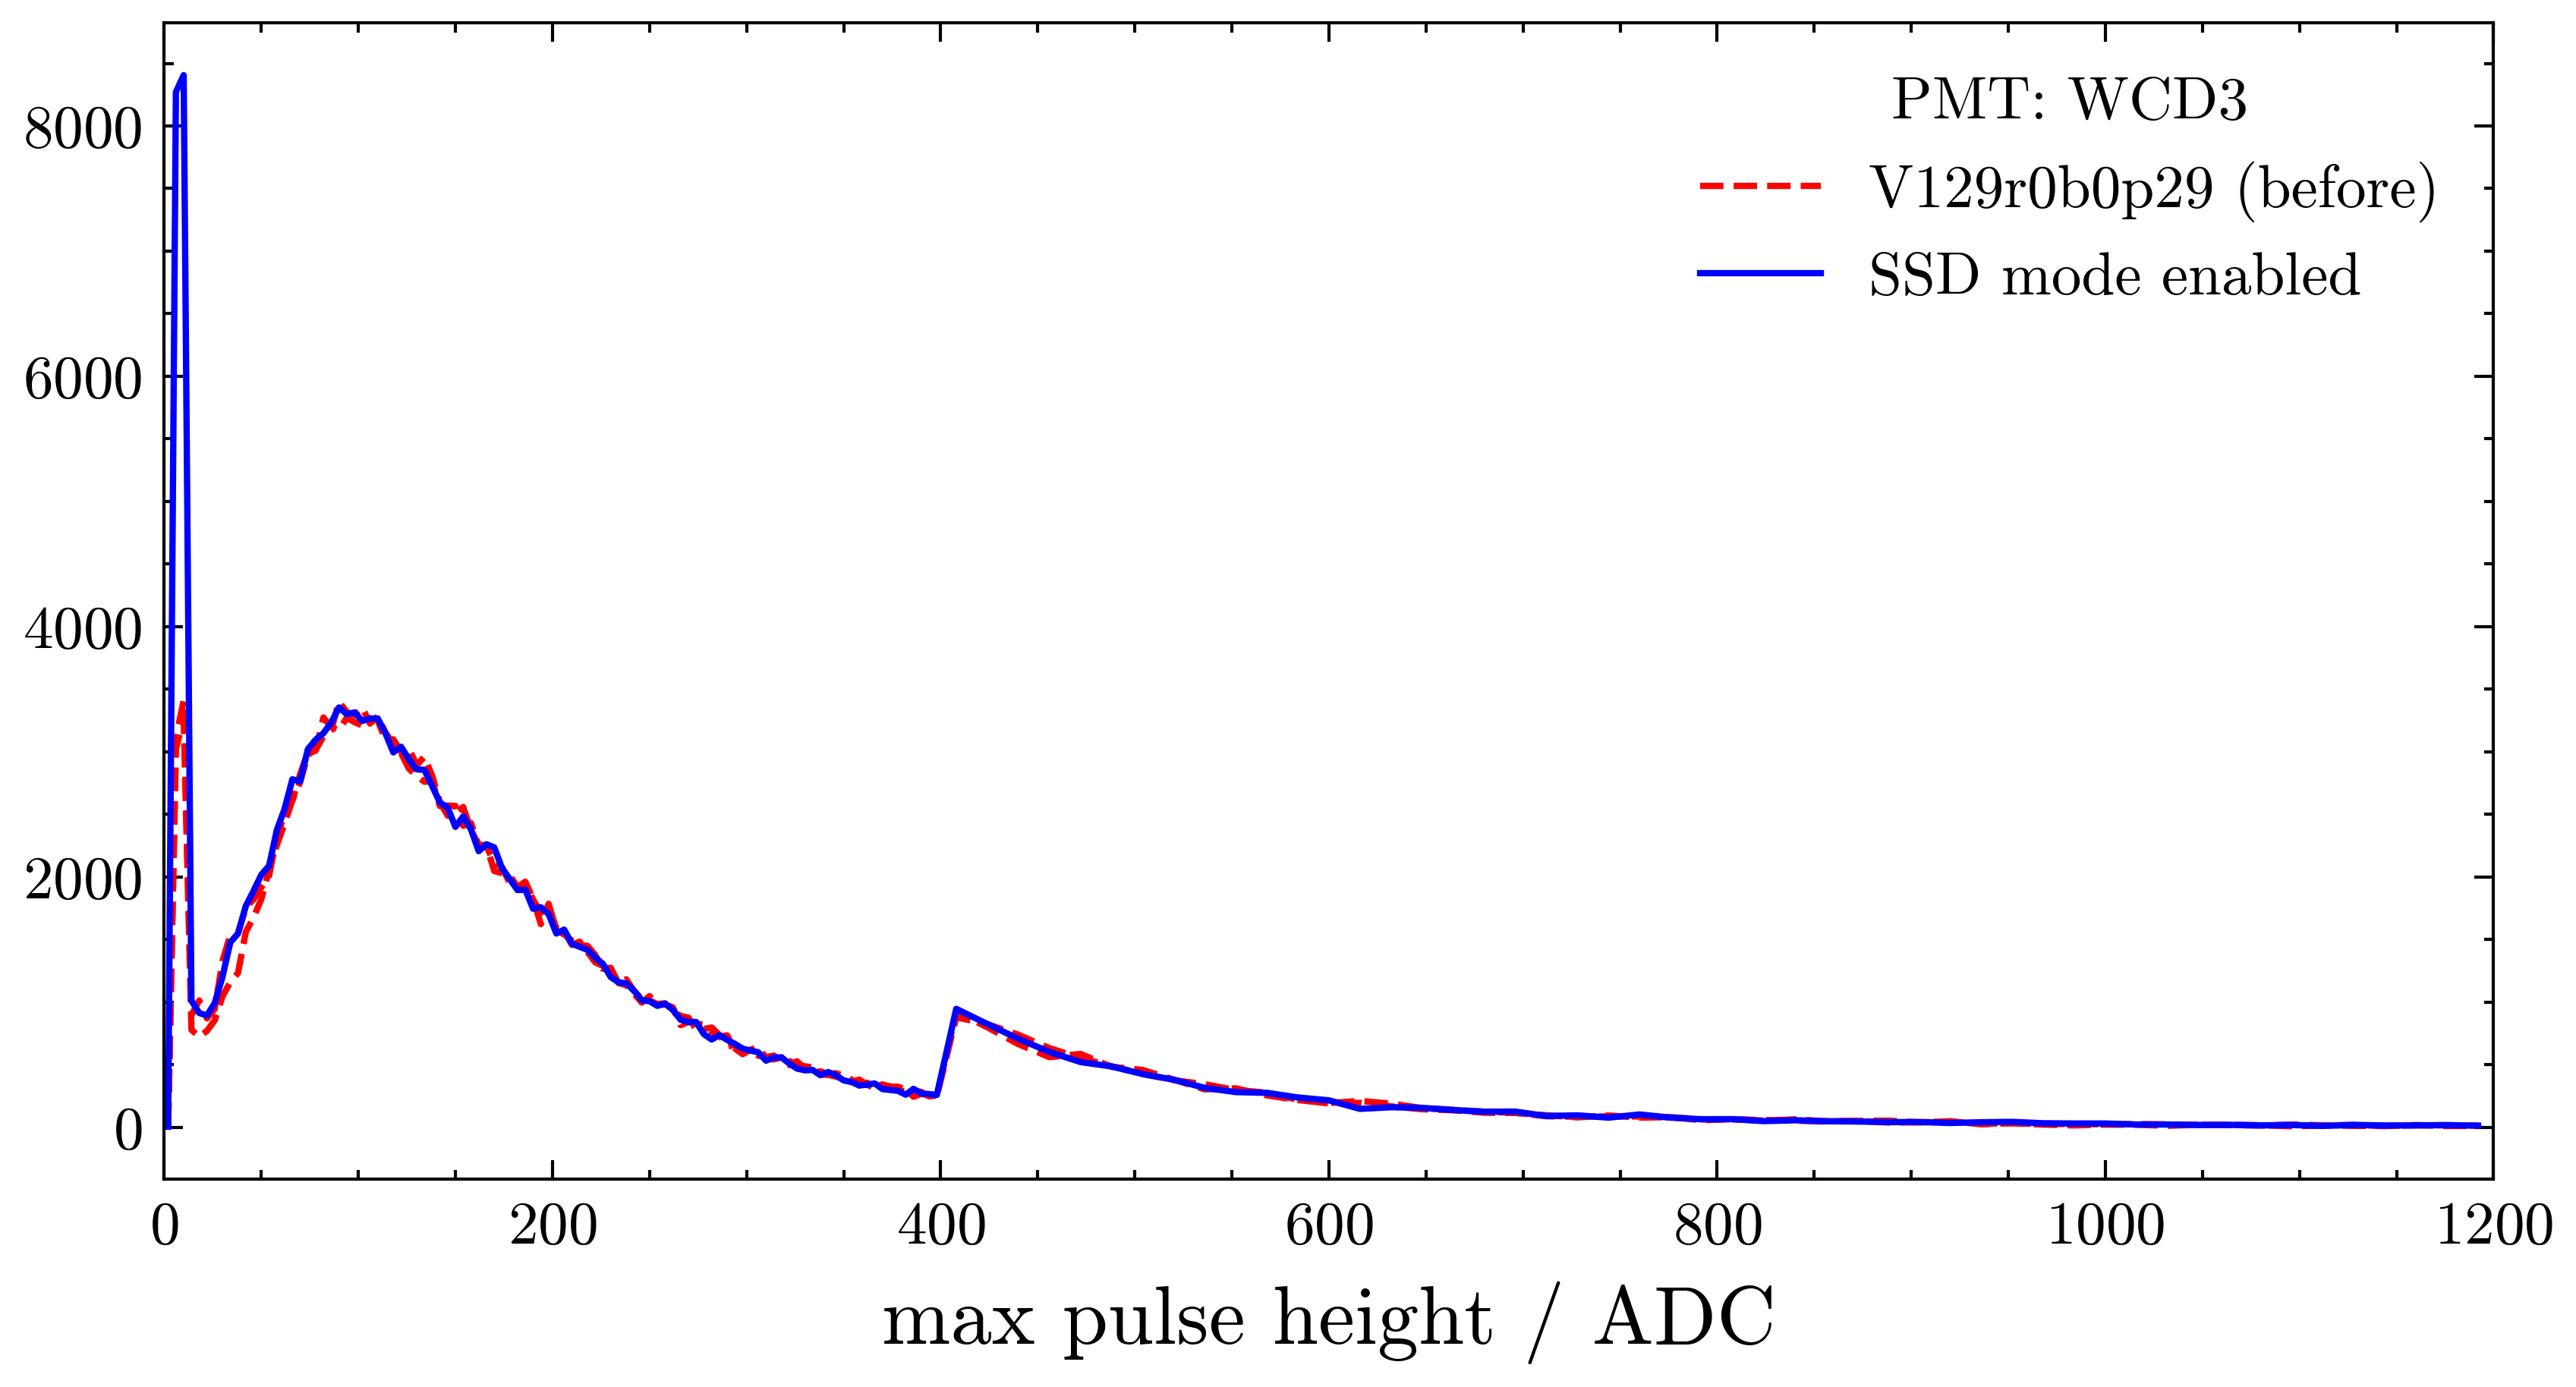

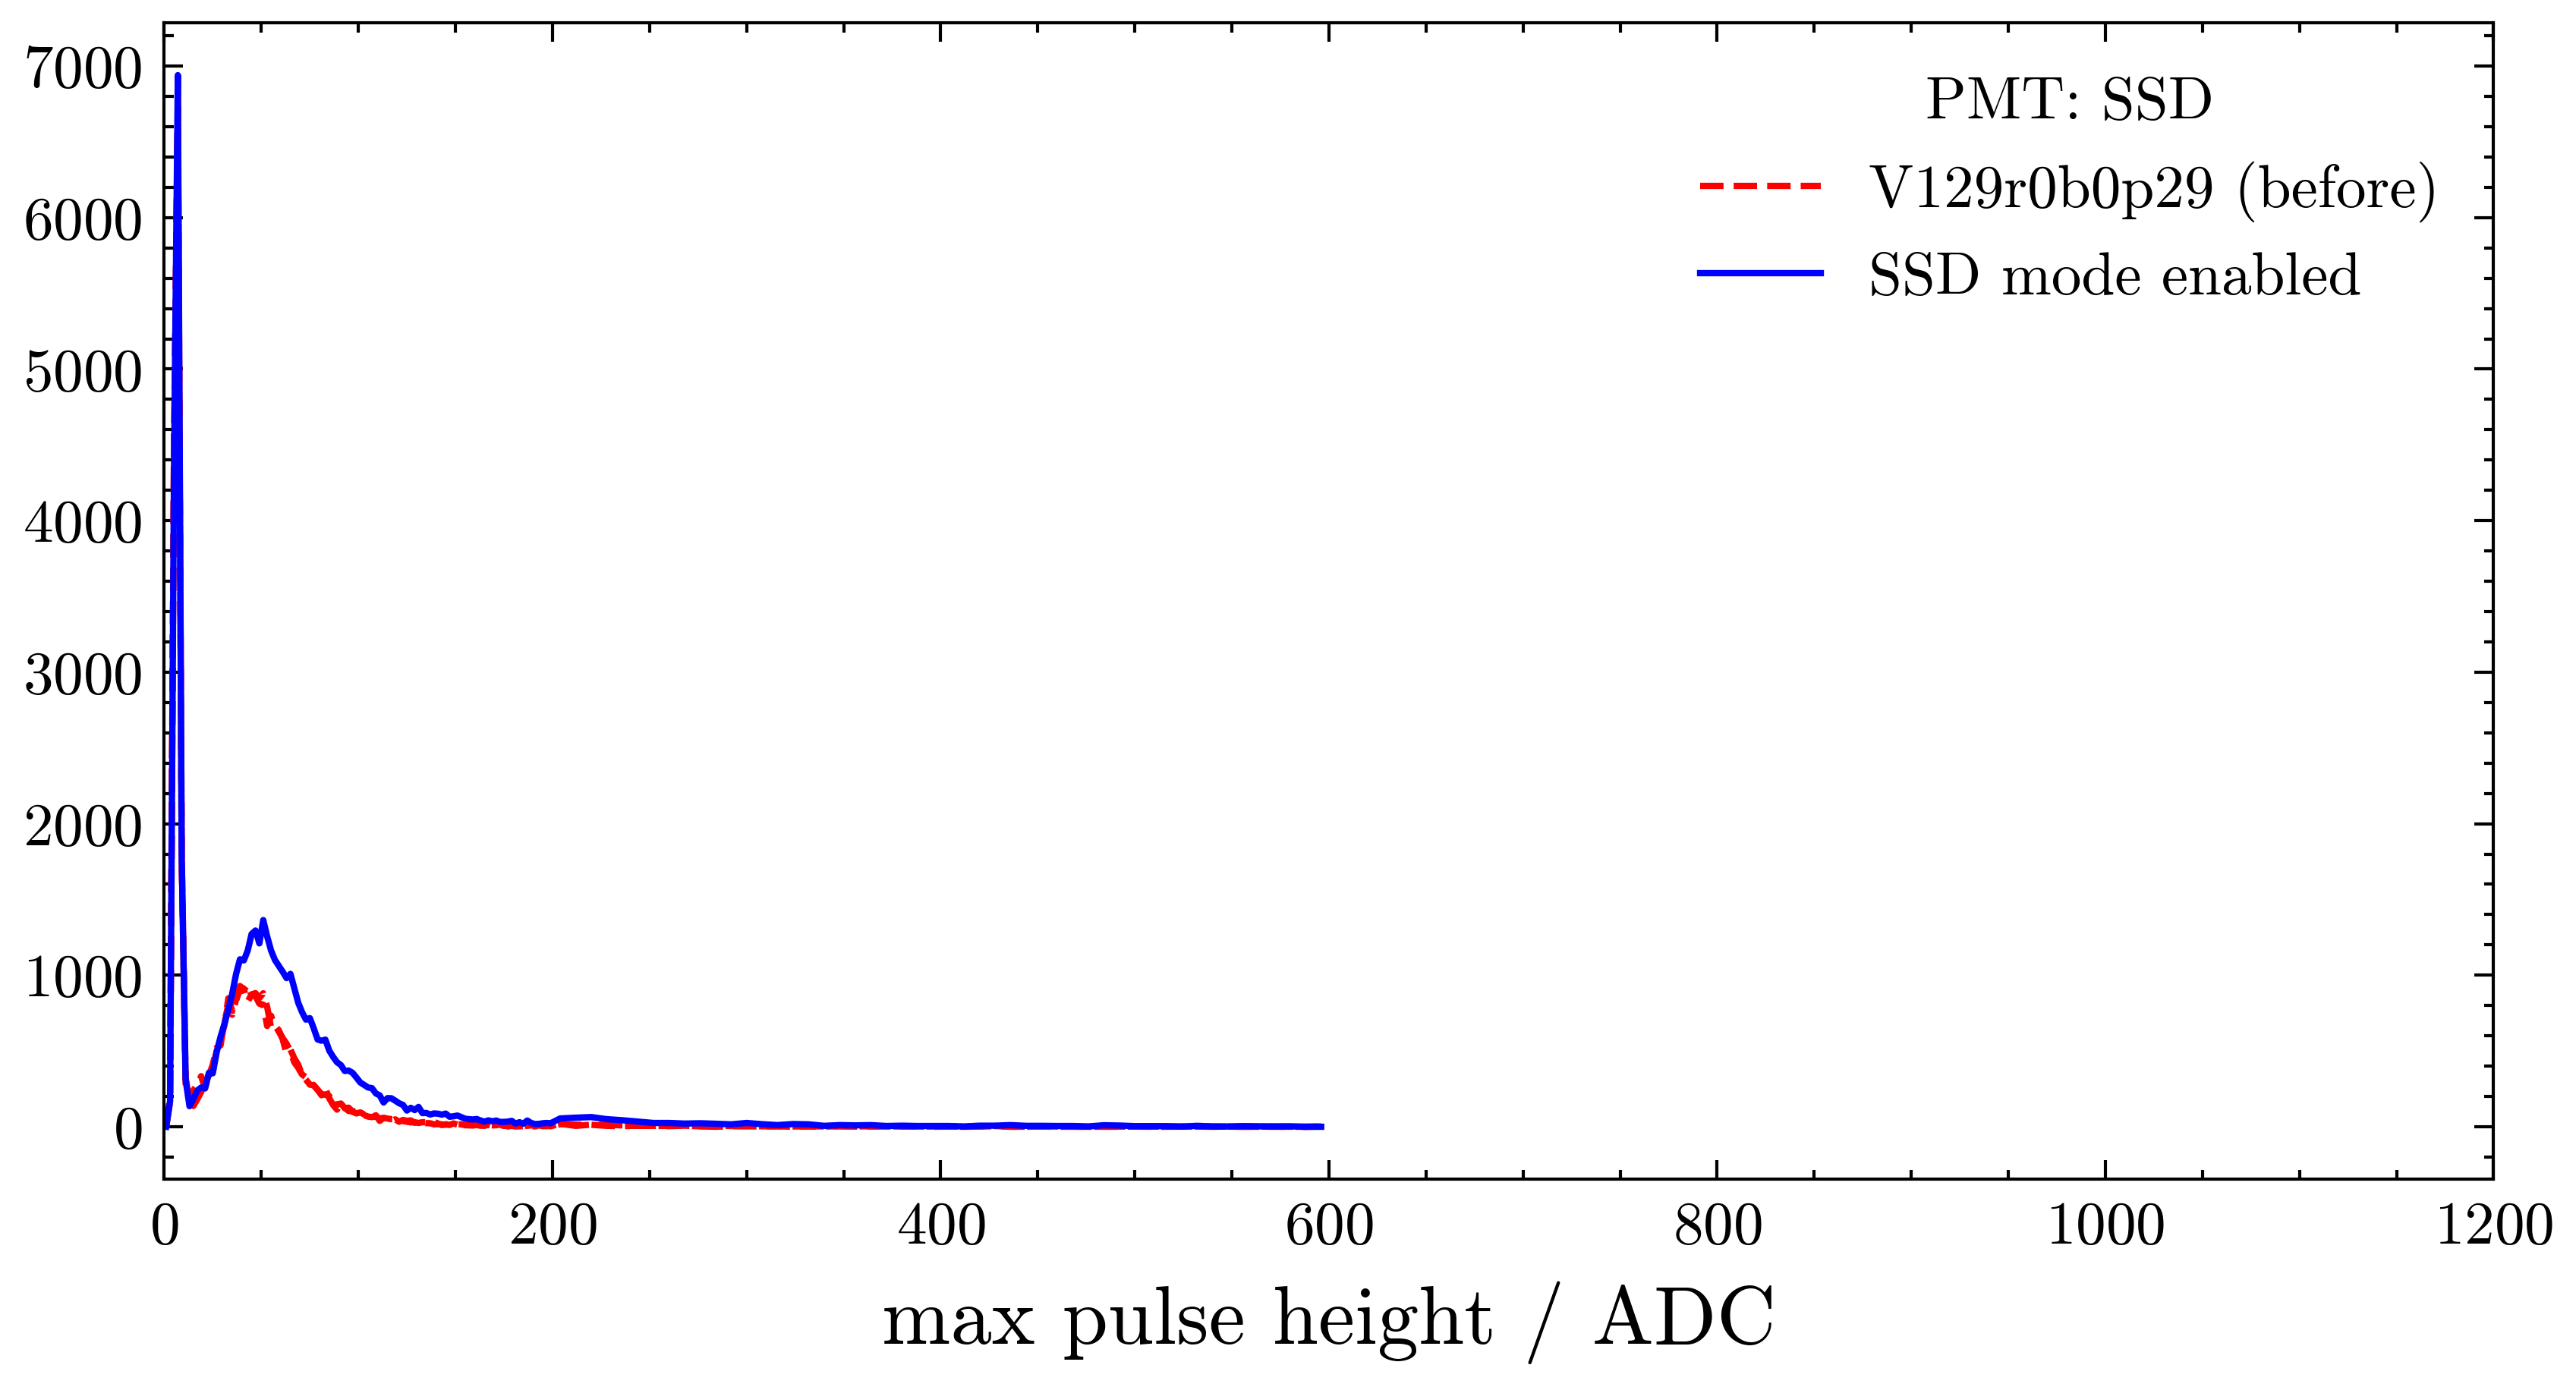

In [5]:
version = 'v26'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

# monit = Monit(*monit_files)
# t, wcd = monit('fTime', 136), monit('fPeak', 136).T
# vem = np.array([np.mean(w) for w in wcd] + [50])

t_acq = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', usecols=[0])
data = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/out.txt')
t_acq += CONSTANTS.GPS_OFFSET
data = data[:, 2:]

start, stop = np.min(t_acq), np.max(t_acq)

daq_start = {
    'v26' : 1727779746,
    'v27' : 1727786803,
    'v28' : 1727793640,
    'v29' : 1727797335,
}

mask_ref1 = np.where(np.logical_and(data[:, 0] < start, data[:, 0] > daq_start[version]))[0]
mask_acq = np.where(np.logical_and(data[:, 0] > start, data[:, 0] < stop))[0]
mask_ref2 = np.where(data[:, 0] > stop)[0]

axes = [plt.subplots()[1] for _ in range(4)]
titles = ['V129r0b0p29 (before)', 'SSD mode enabled']

for title, color, ls, mask in zip(titles, ['r', 'b', 'k'], ['--', 'solid', ':'], [mask_ref1, mask_acq, mask_ref2]):
    firsttime = True
        
    for histo in data[mask]:
        t, pmt, *histo = histo
        bins = CONSTANTS.UUB_SSD_BIN_CENTERS if pmt == 3 else CONSTANTS.UUB_WCD_BIN_CENTERS

        if firsttime:
            axes[int(pmt)].plot(bins, histo, c=color, ls=ls, label=title)
        else:
            axes[int(pmt)].plot(bins, histo, c=color, ls=ls)

        if pmt == 3: firsttime = False

title = ['WCD1', 'WCD2', 'WCD3', 'SSD']
for i in range(4):
    axes[i].legend(title=f"PMT: {title[i]}")
    axes[i].set_xlabel("max pulse height / ADC")
    axes[i].axvline(start, c='k', ls='--', lw=0.8)
    axes[i].axvline(stop, c='k', ls='--', lw=0.8)
    axes[i].set_xlim(0, 1200)


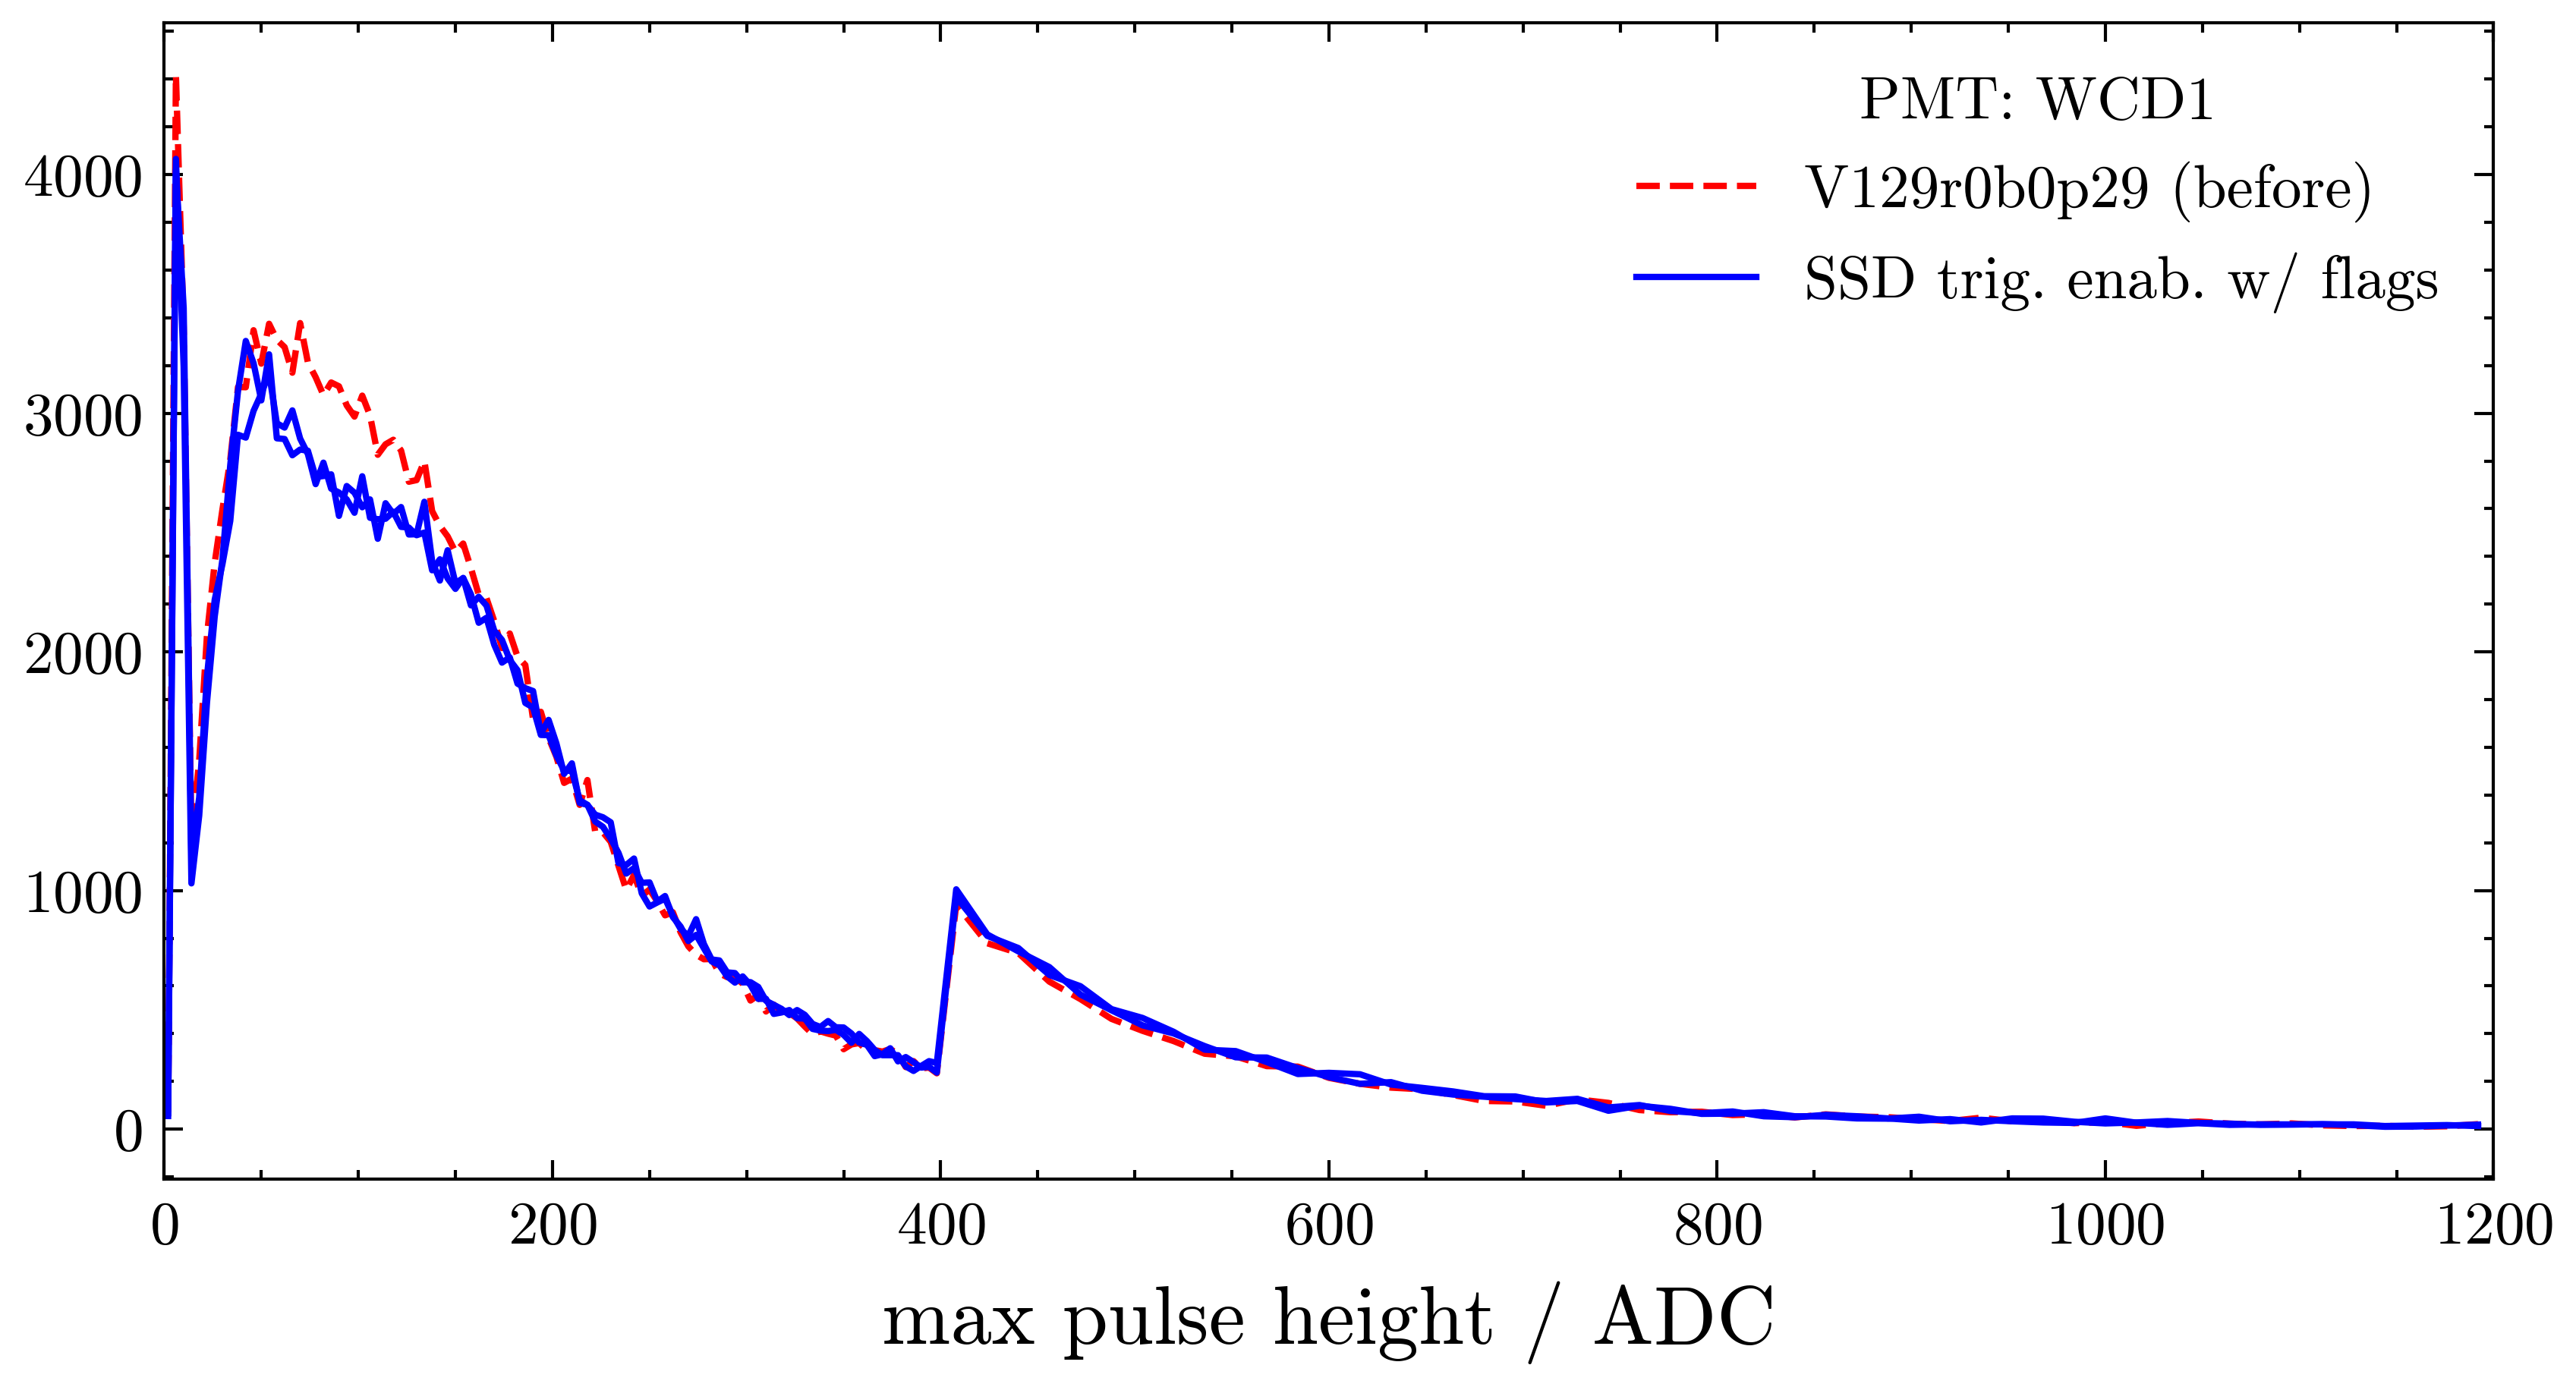

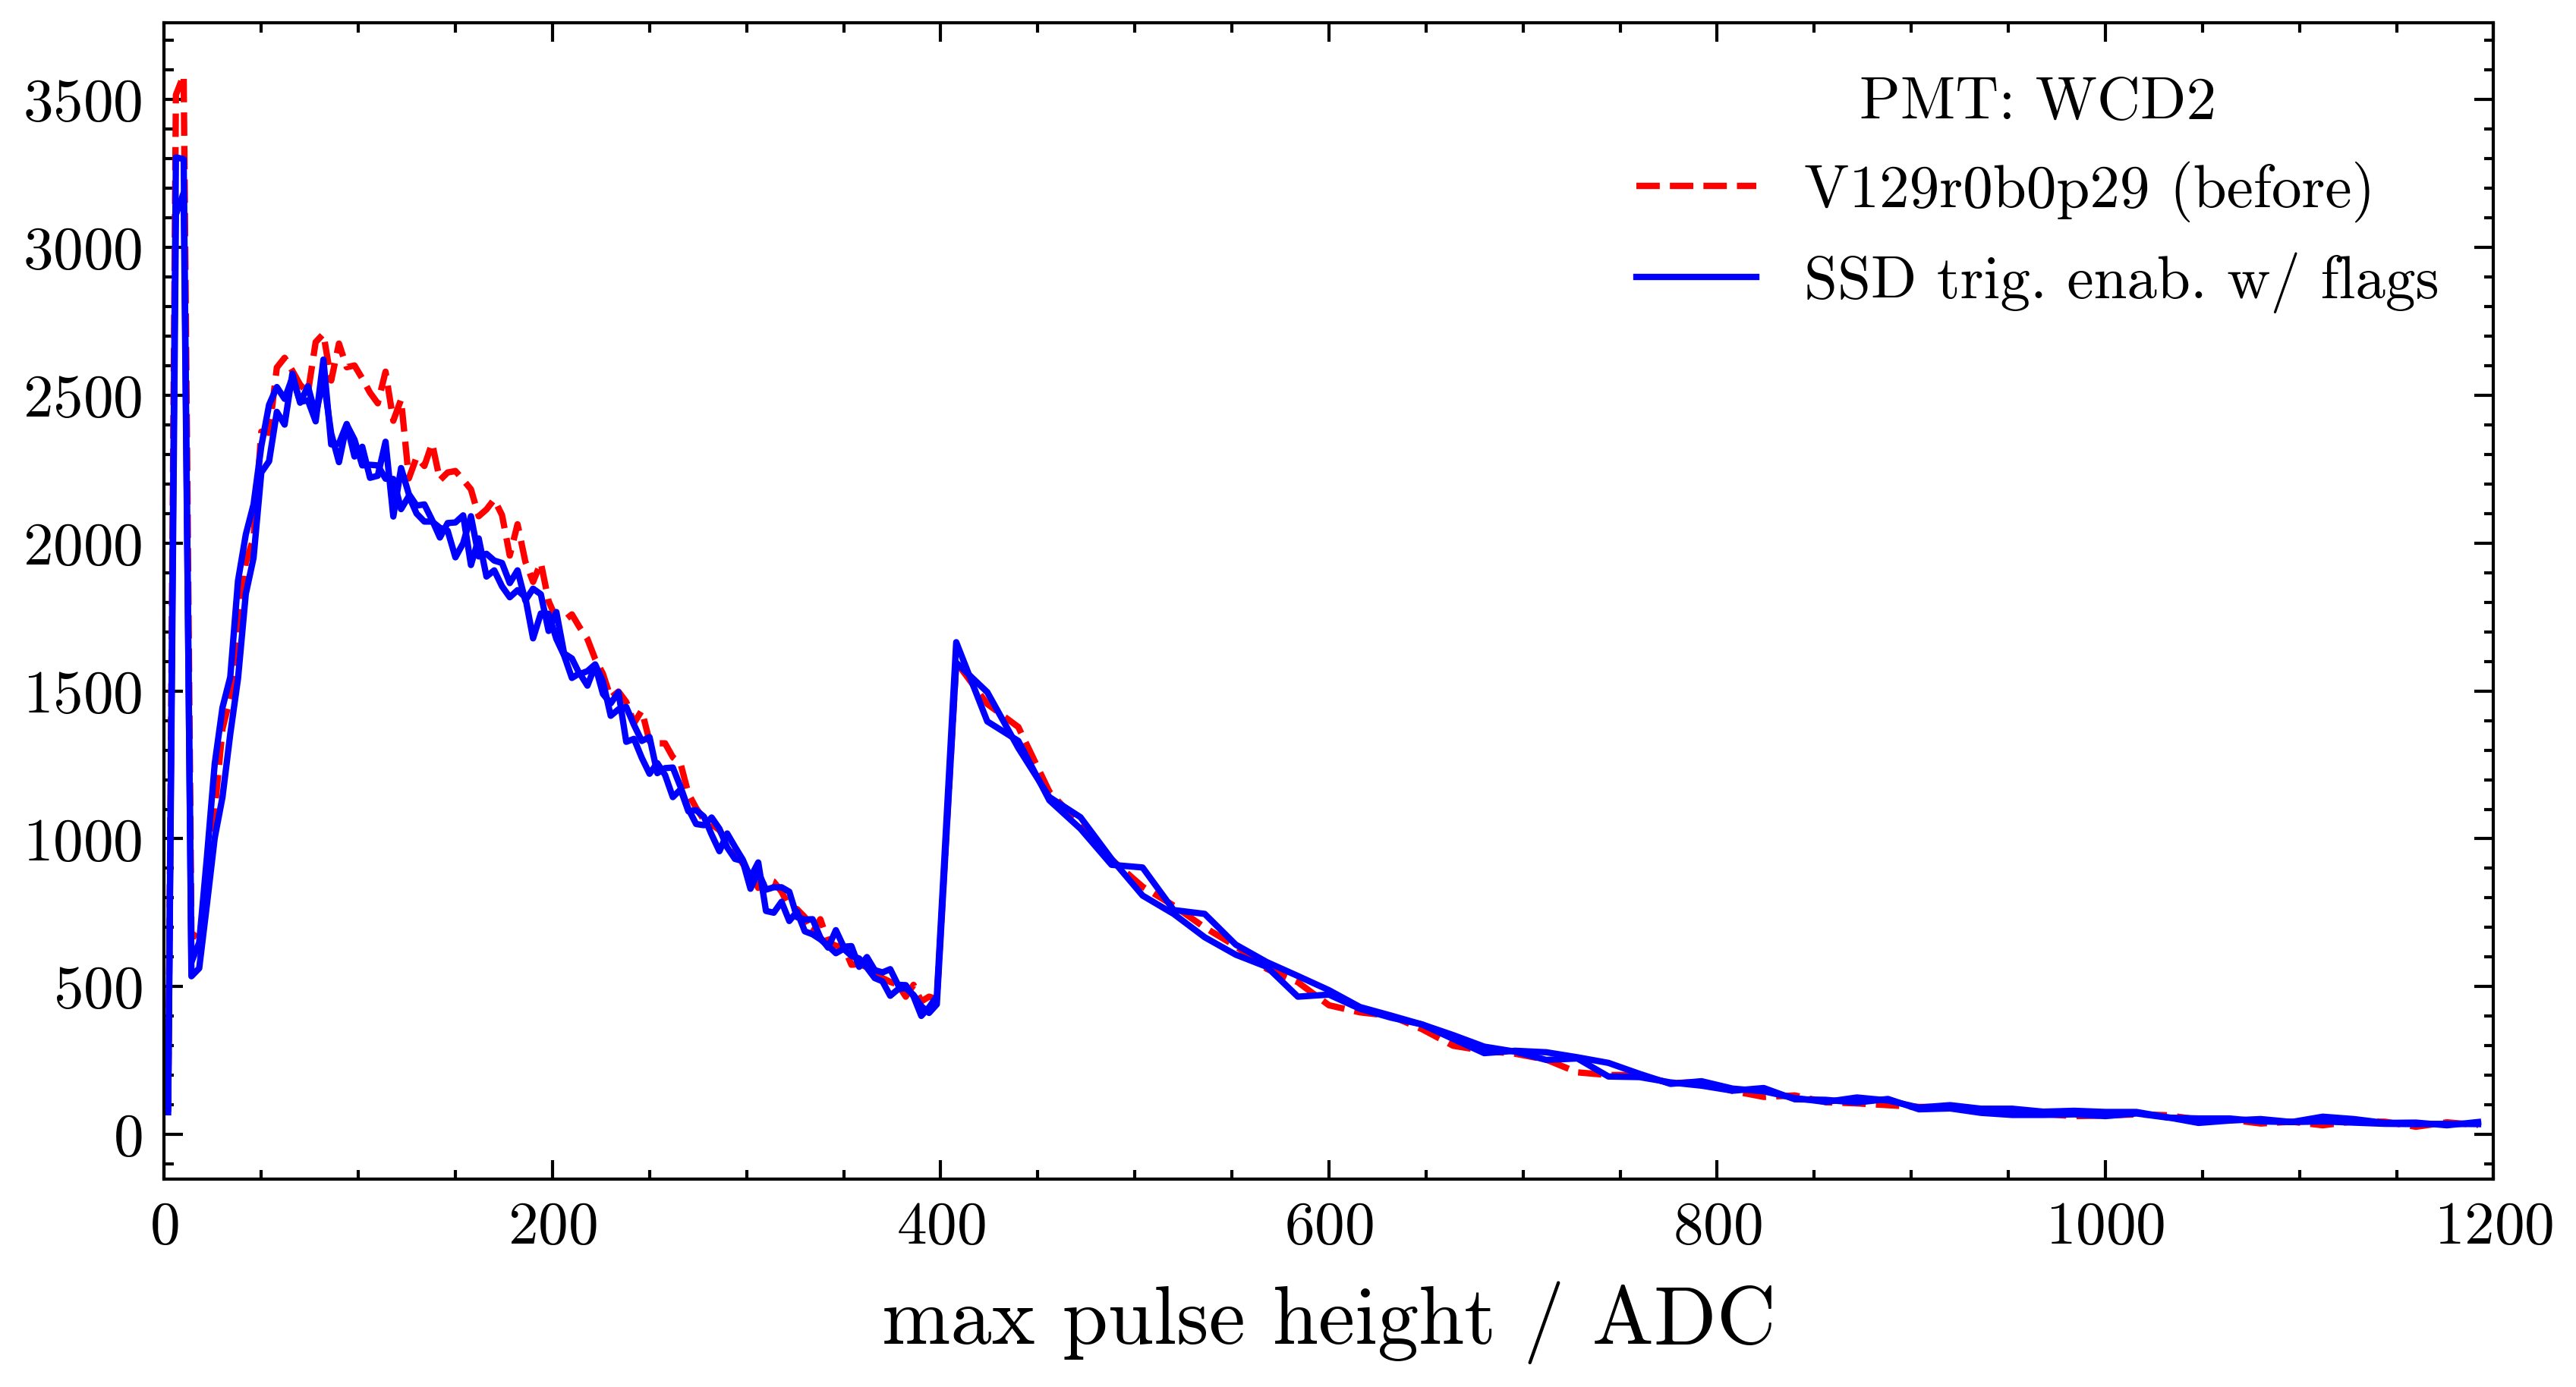

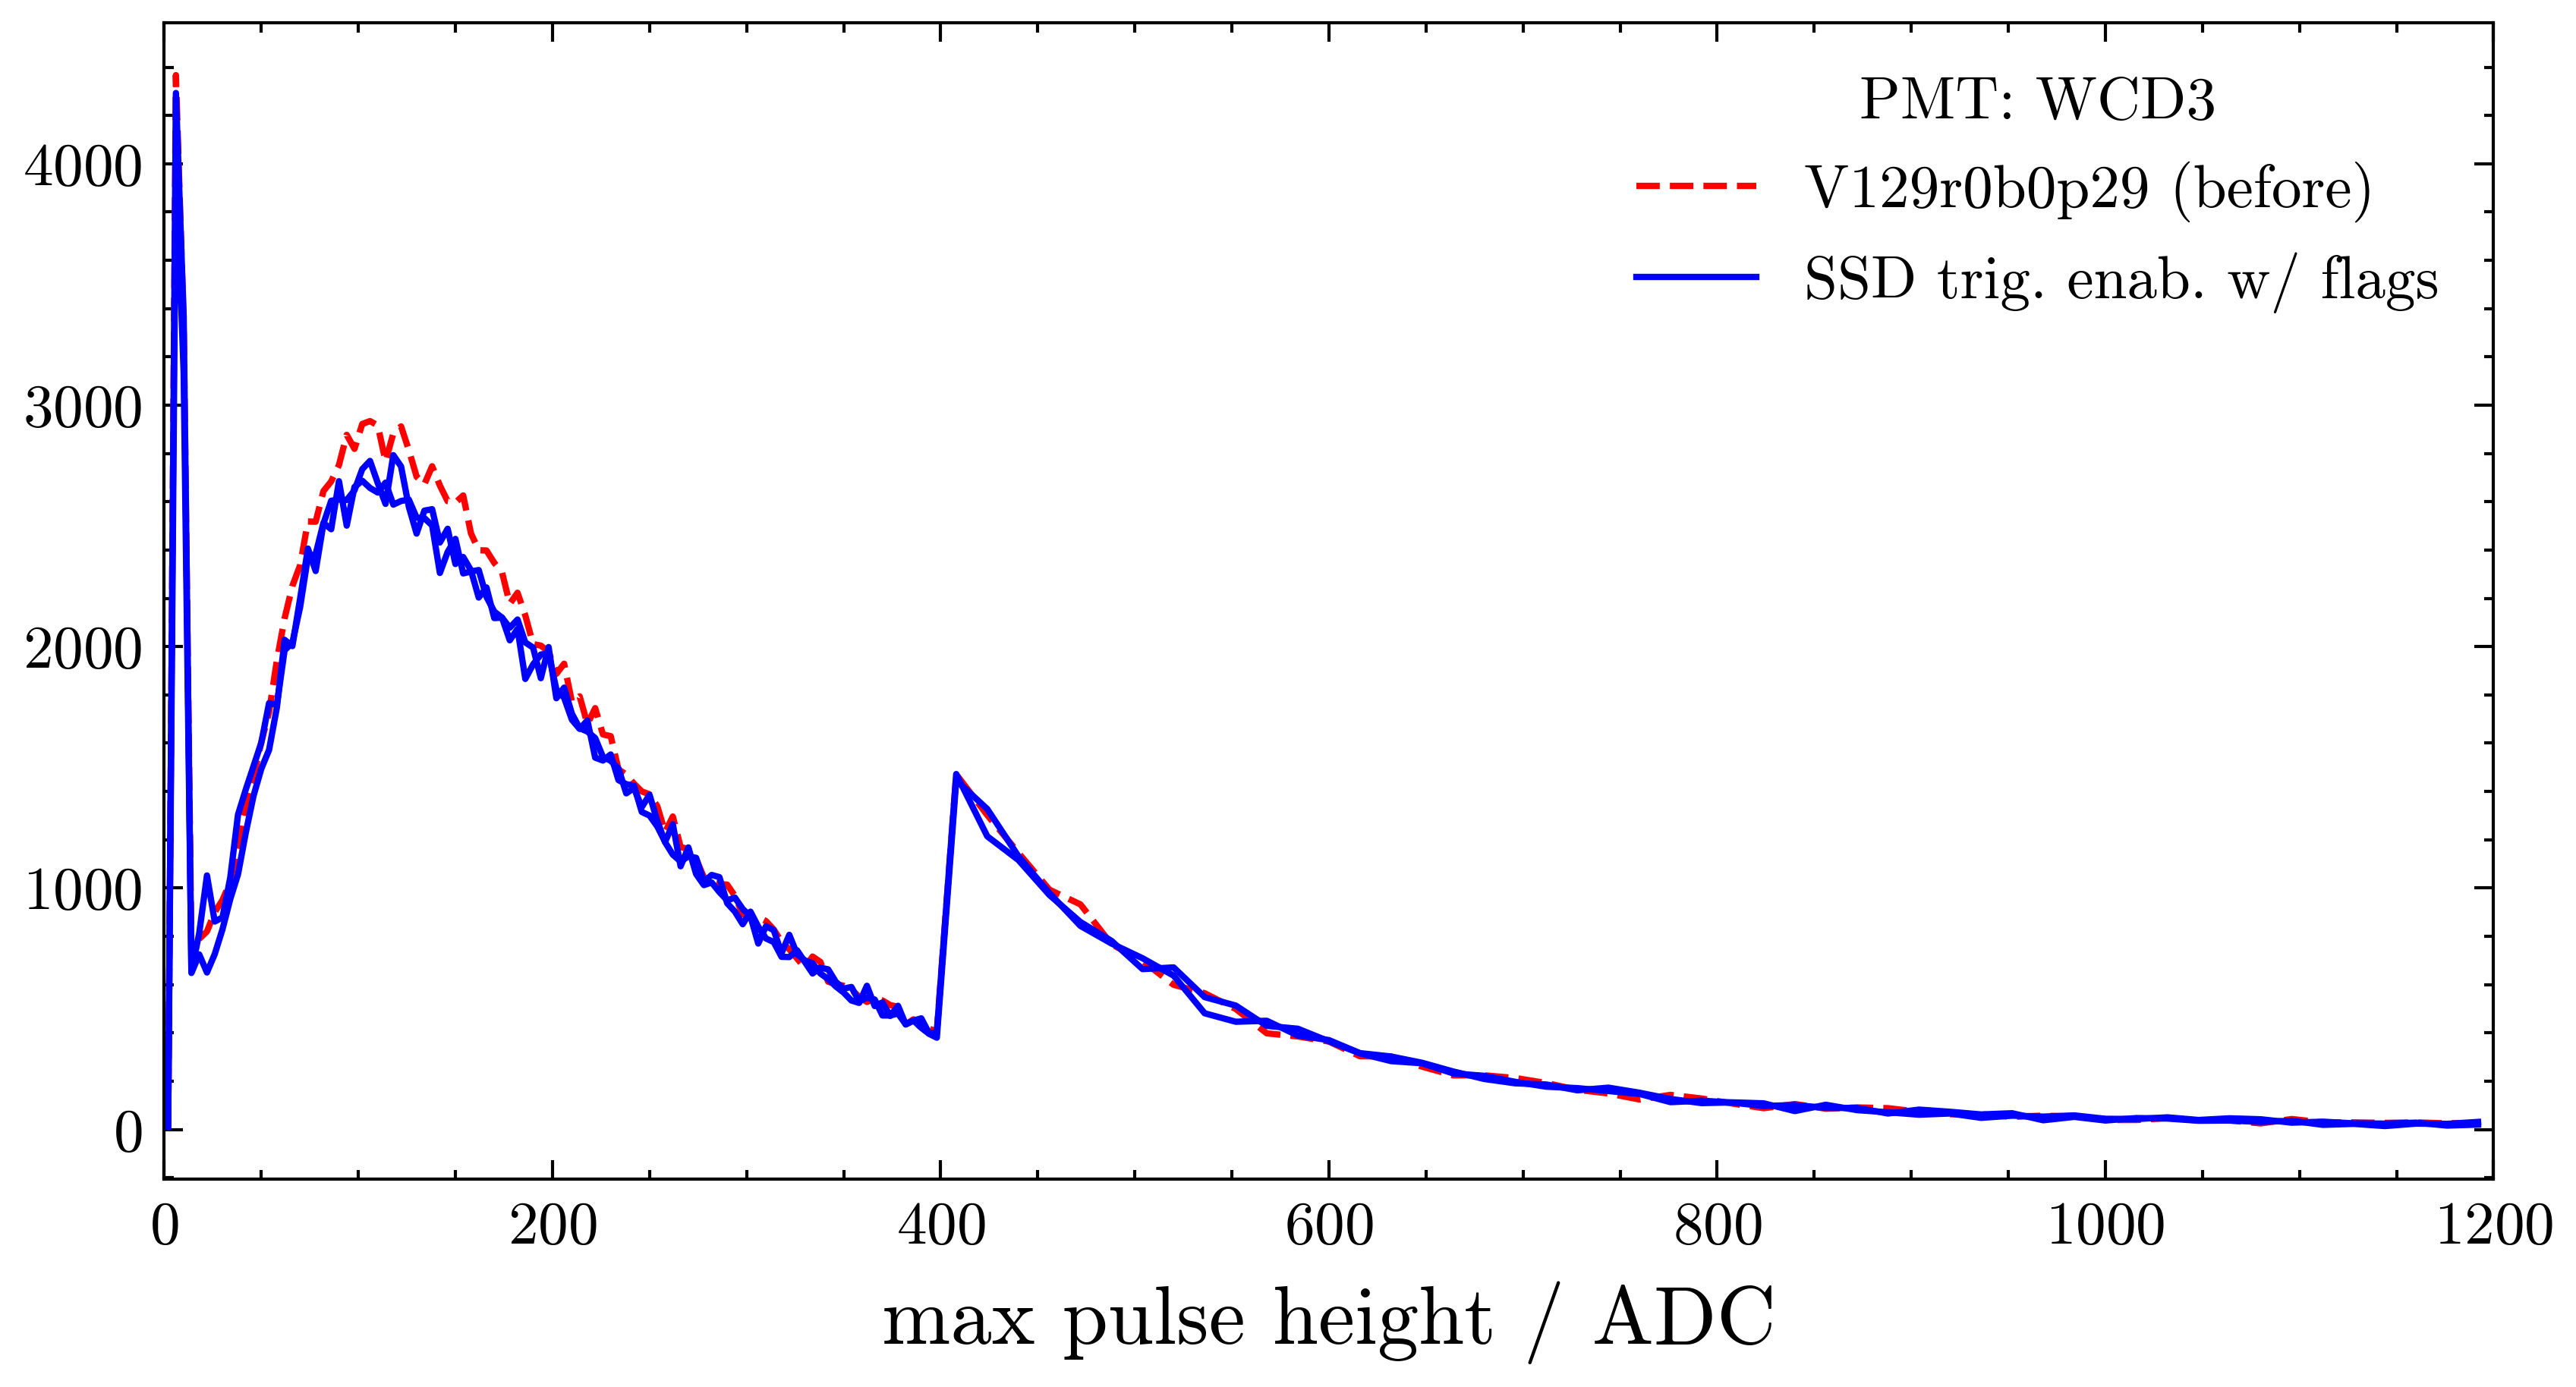

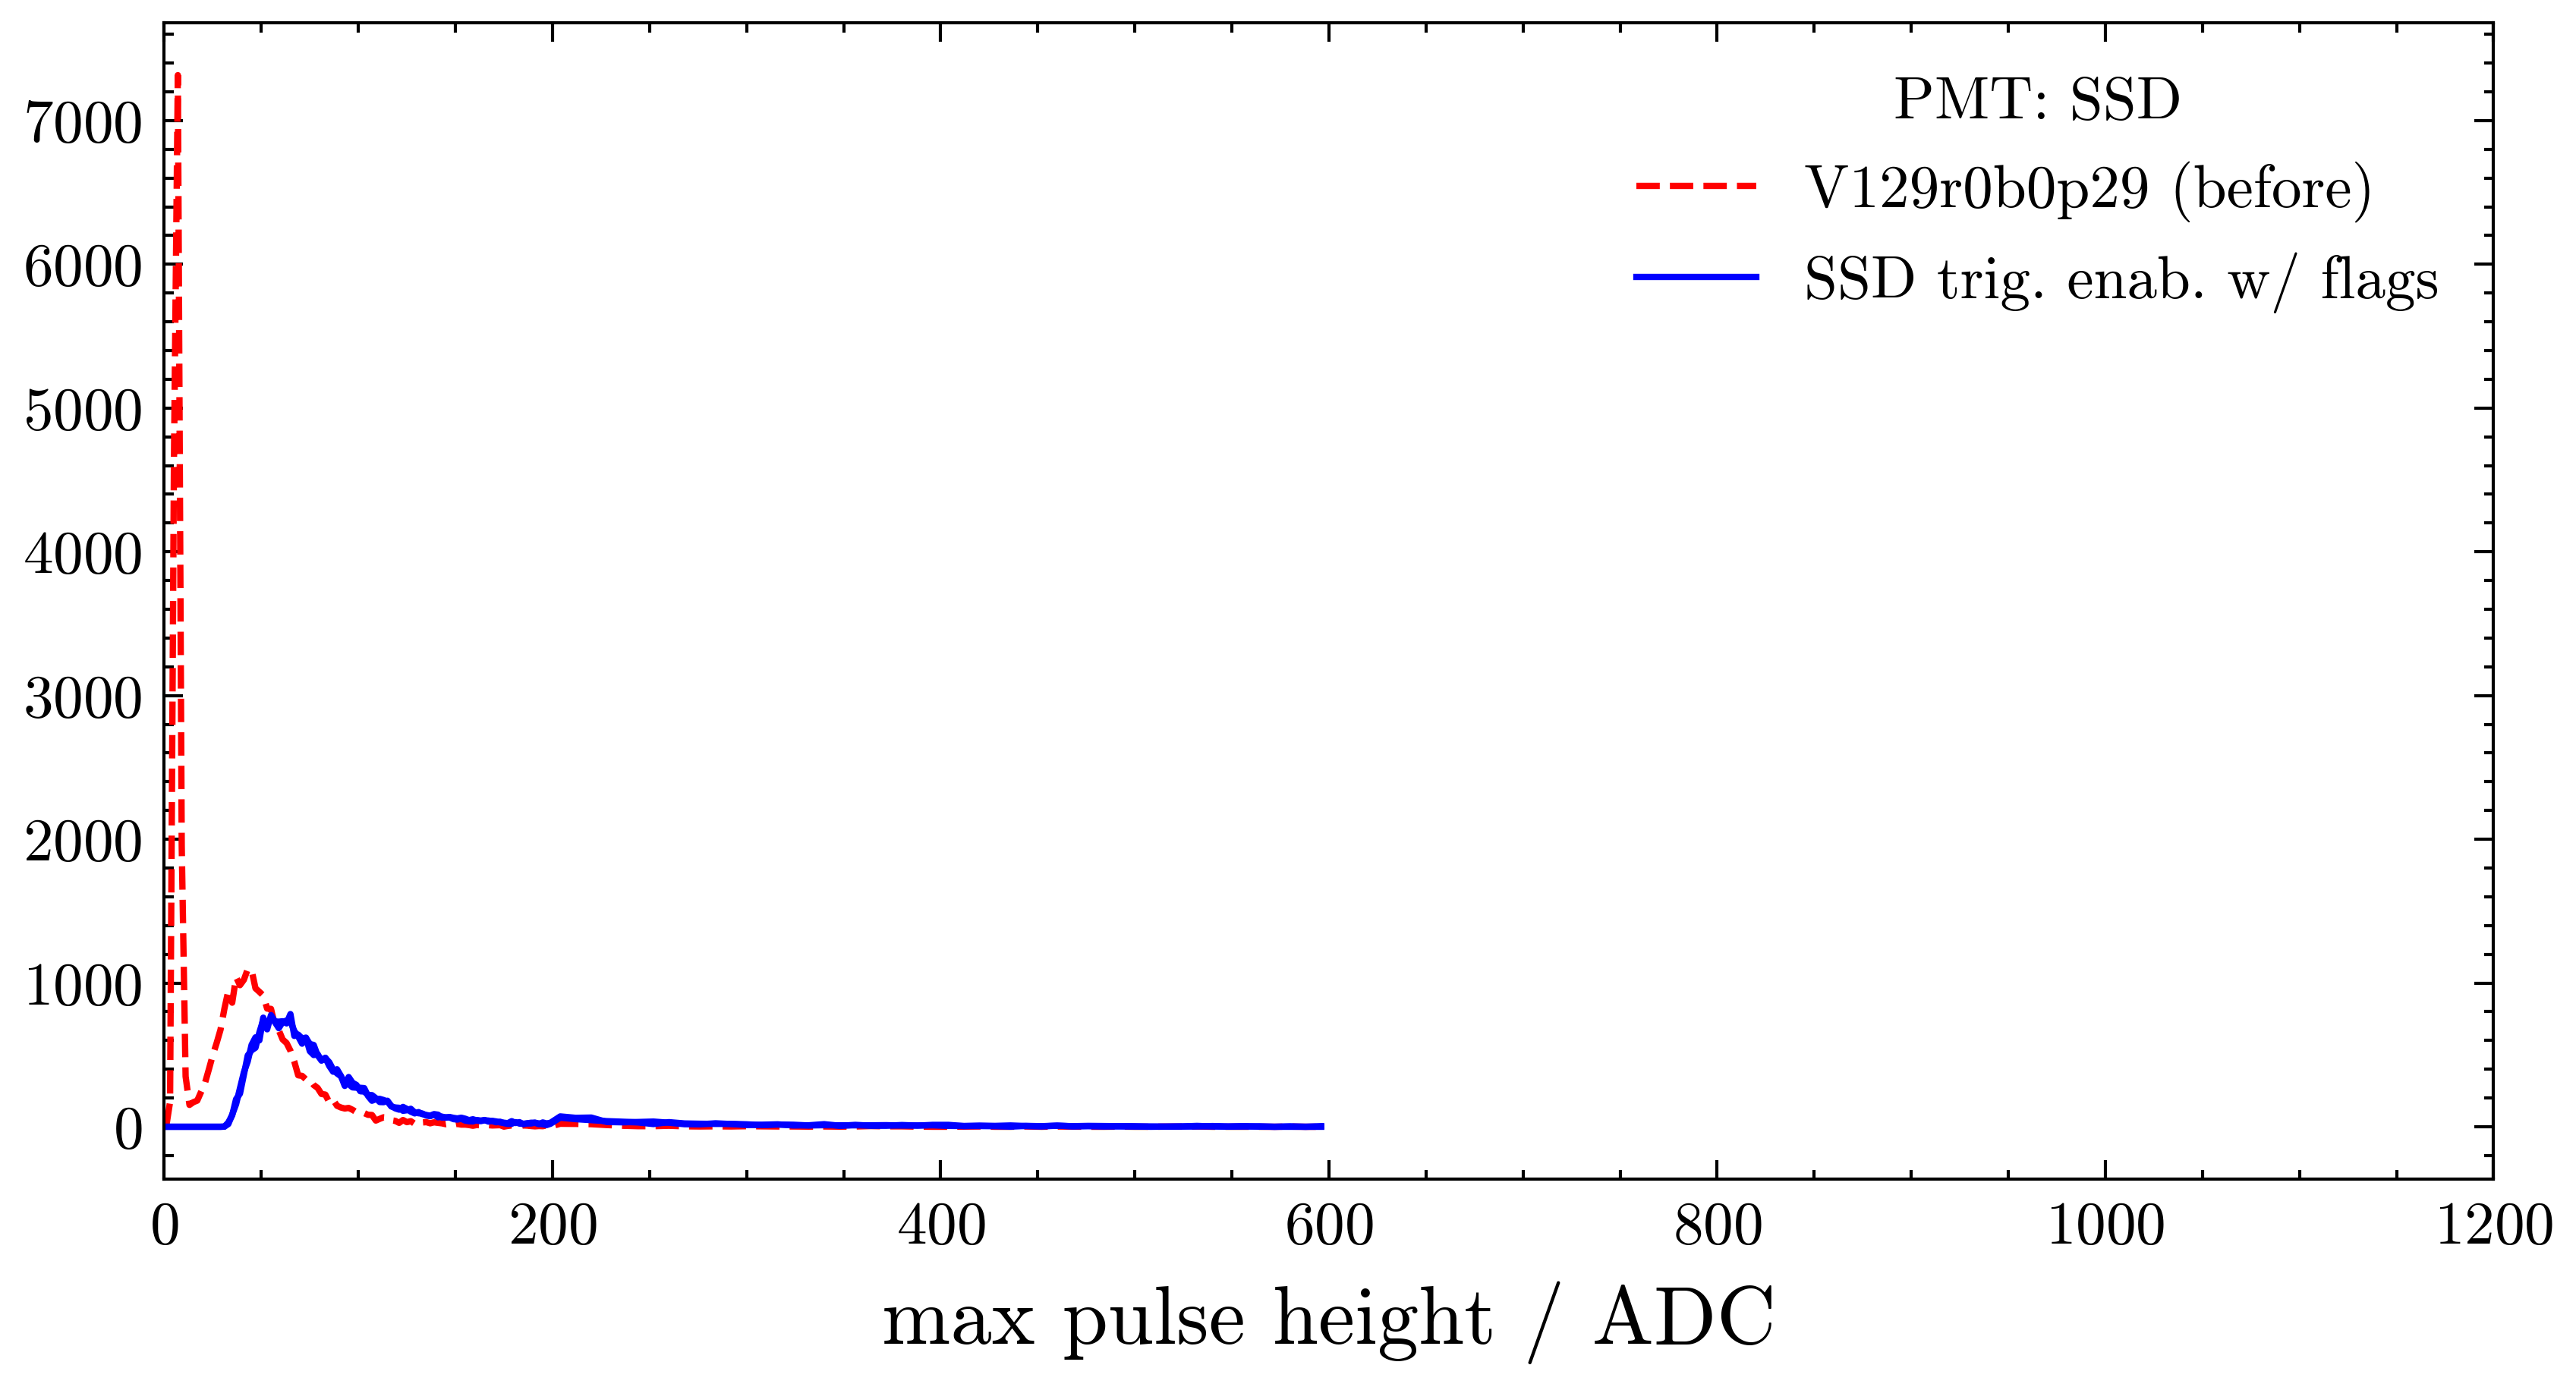

In [8]:
version = 'v29'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

# monit = Monit(*monit_files)
# t, wcd = monit('fTime', 136), monit('fPeak', 136).T
# vem = np.array([np.mean(w) for w in wcd] + [50])

t_acq = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', usecols=[0])
data = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/out.txt')
t_acq += CONSTANTS.GPS_OFFSET
data = data[:, 2:]

start, stop = np.min(t_acq), np.max(t_acq)

daq_start = {
    'v26' : 1727779746,
    'v27' : 1727786803,
    'v28' : 1727793640,
    'v29' : 1727797335,
}

mask_ref1 = np.where(np.logical_and(data[:, 0] < start, data[:, 0] > daq_start[version]))[0]
mask_acq = np.where(np.logical_and(data[:, 0] > start, data[:, 0] < stop))[0]
mask_ref2 = np.where(data[:, 0] > stop)[0]

axes = [plt.subplots()[1] for _ in range(4)]
titles = ['V129r0b0p29 (before)', 'SSD trig. enab. w/ flags']

for title, color, ls, mask in zip(titles, ['r', 'b', 'k'], ['--', 'solid', ':'], [mask_ref1, mask_acq, mask_ref2]):
    firsttime = True
        
    for histo in data[mask]:
        t, pmt, *histo = histo
        bins = CONSTANTS.UUB_SSD_BIN_CENTERS if pmt == 3 else CONSTANTS.UUB_WCD_BIN_CENTERS

        if firsttime:
            axes[int(pmt)].plot(bins, histo, c=color, ls=ls, label=title)
        else:
            axes[int(pmt)].plot(bins, histo, c=color, ls=ls)

        if pmt == 3: firsttime = False

title = ['WCD1', 'WCD2', 'WCD3', 'SSD']
for i in range(4):
    axes[i].legend(title=f"PMT: {title[i]}")
    axes[i].set_xlabel("max pulse height / ADC")
    axes[i].axvline(start, c='k', ls='--', lw=0.8)
    axes[i].axvline(stop, c='k', ls='--', lw=0.8)
    axes[i].set_xlim(0, 1200)


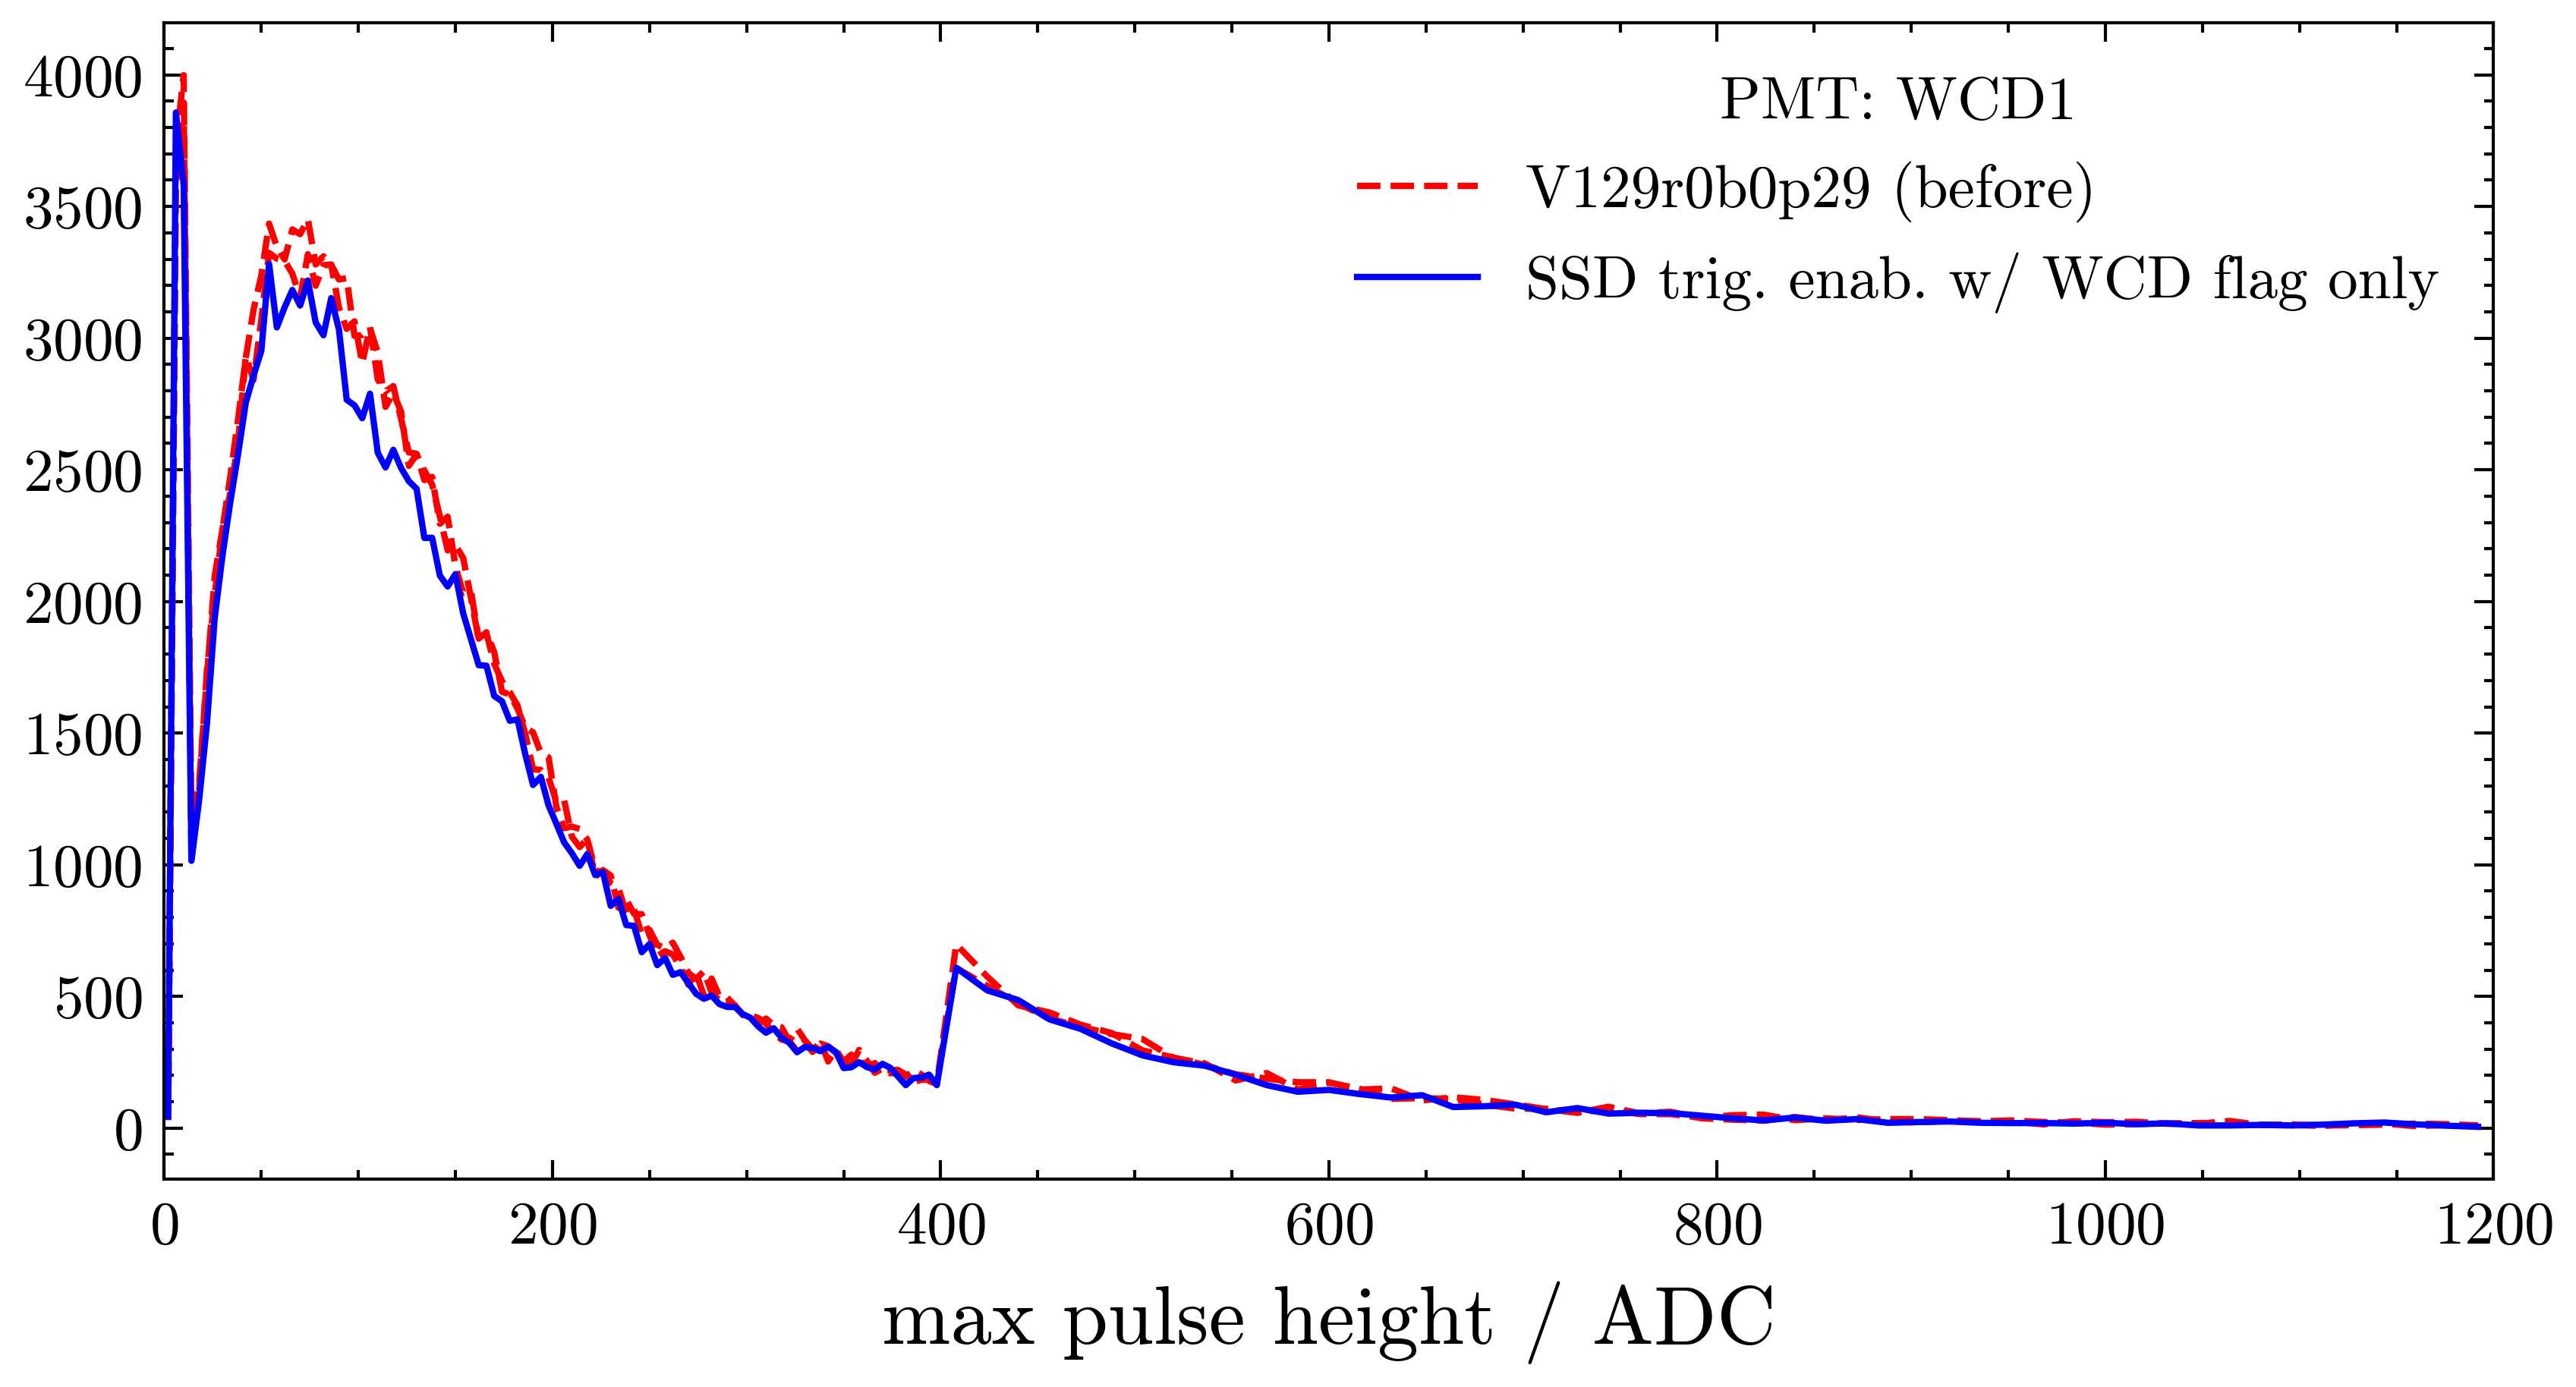

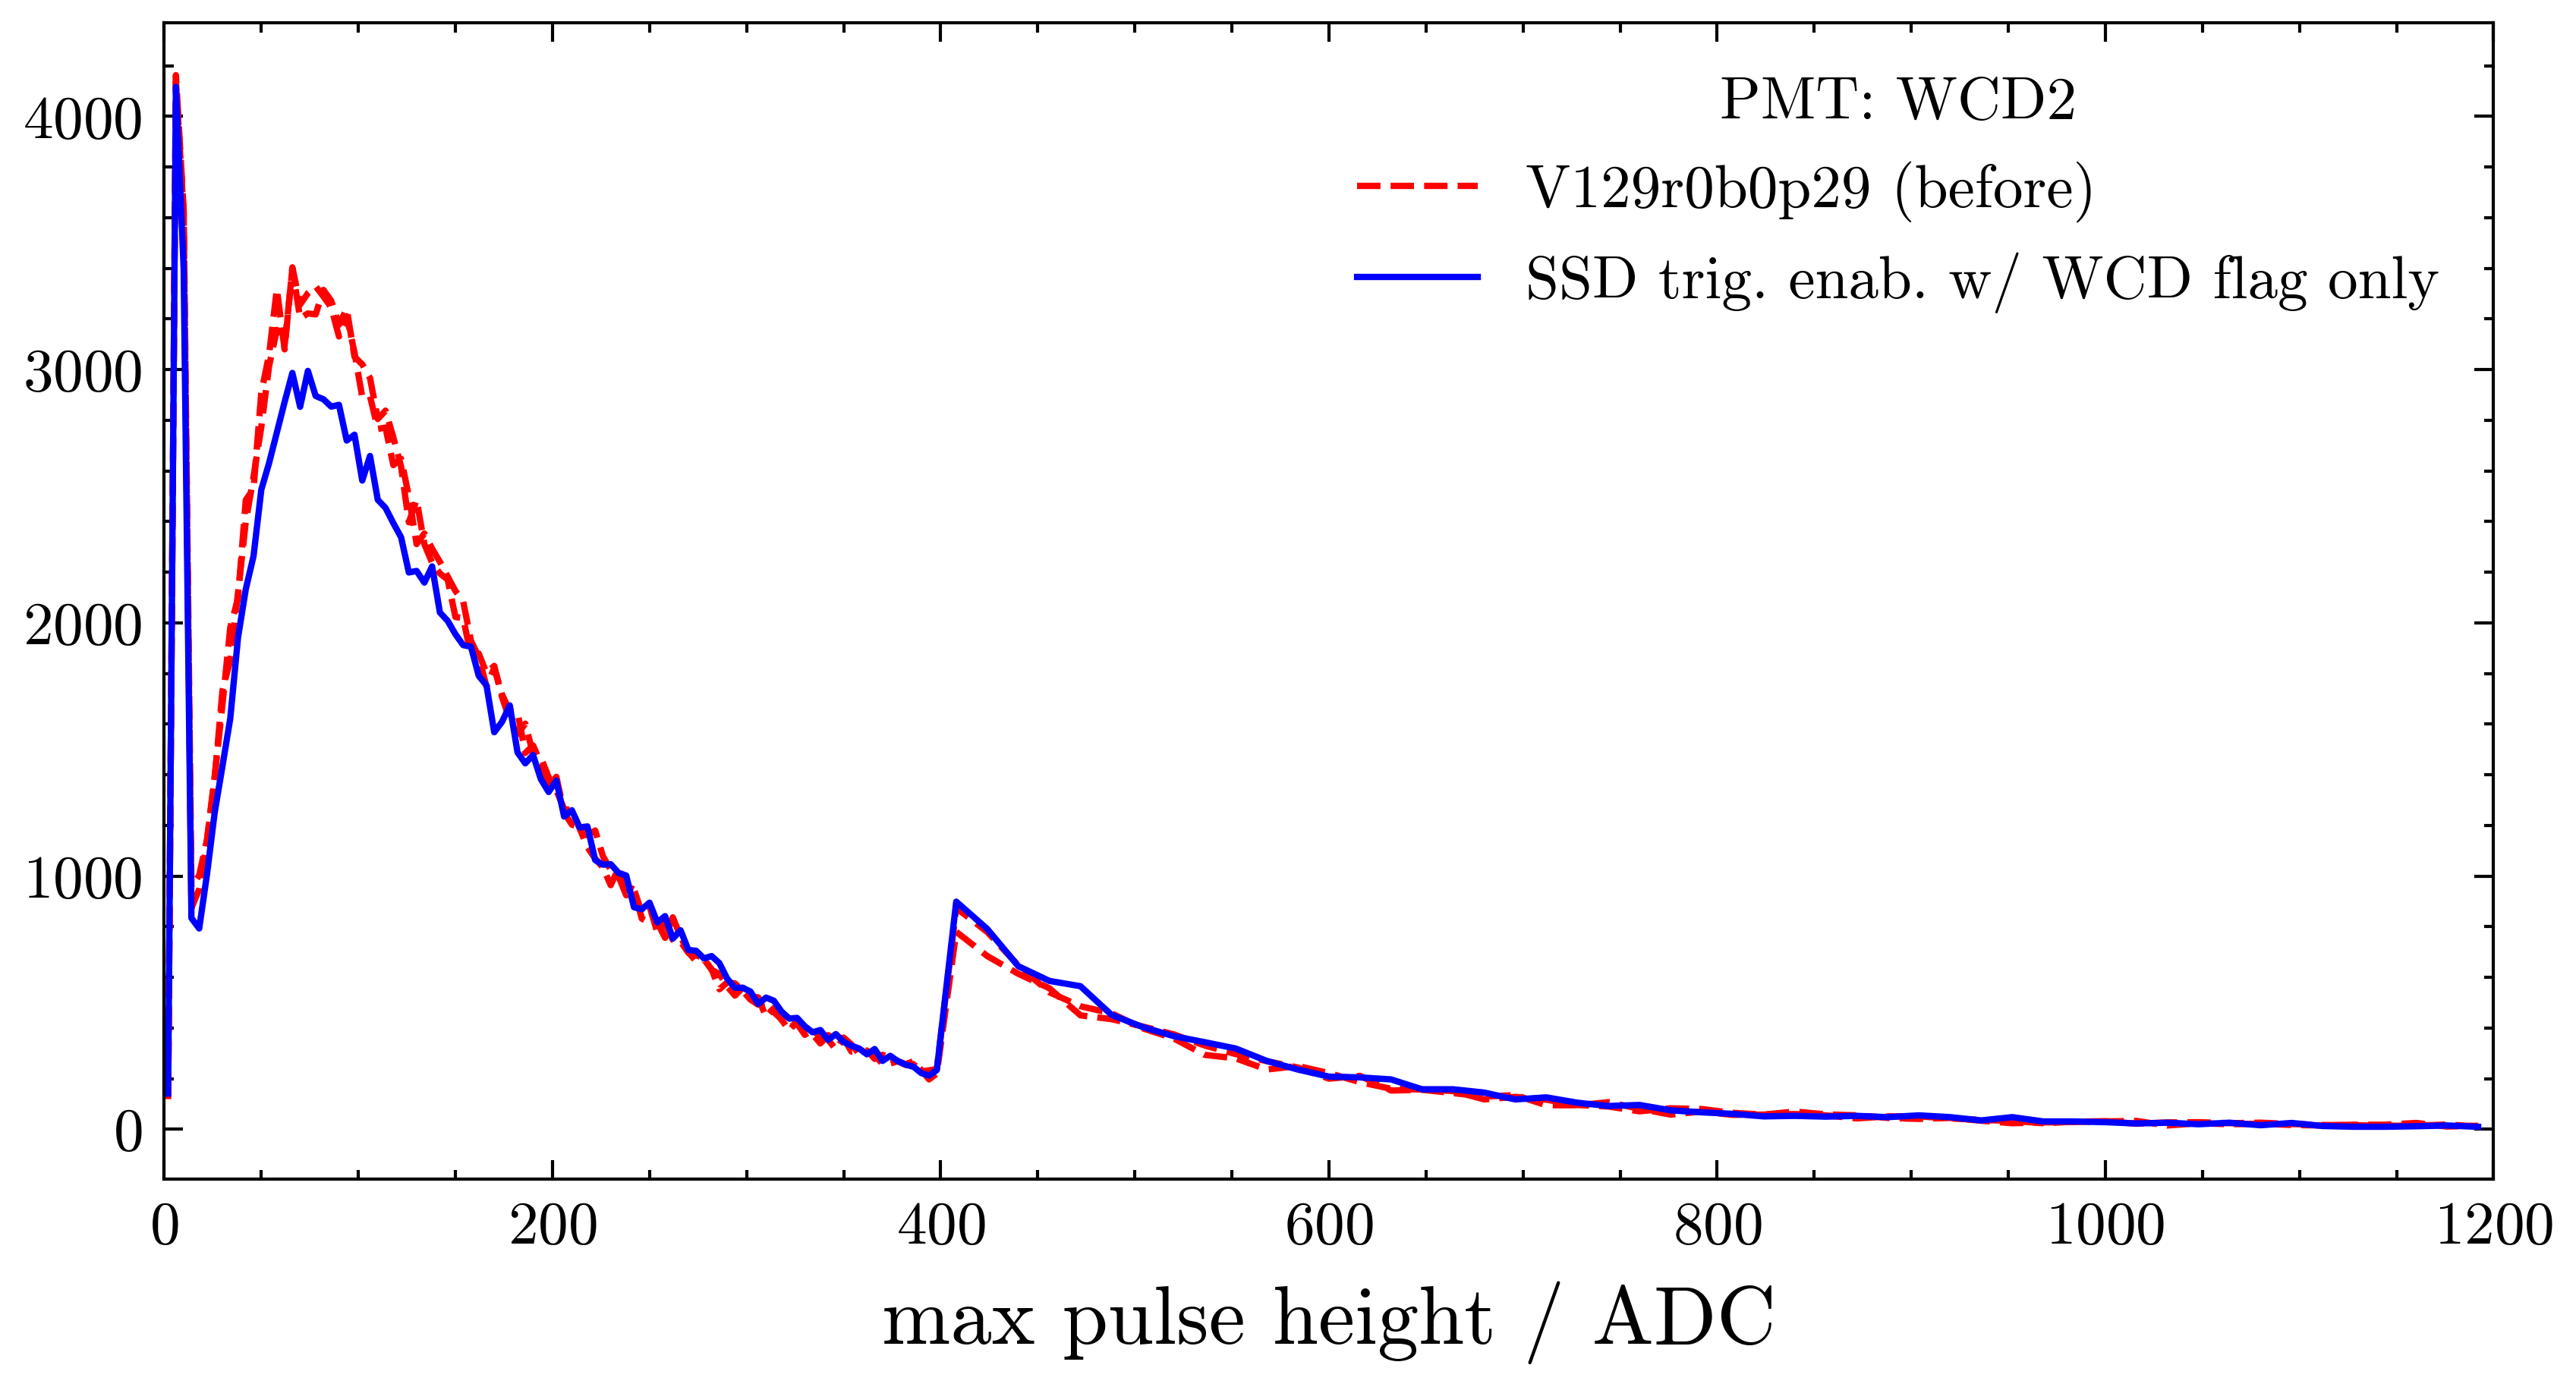

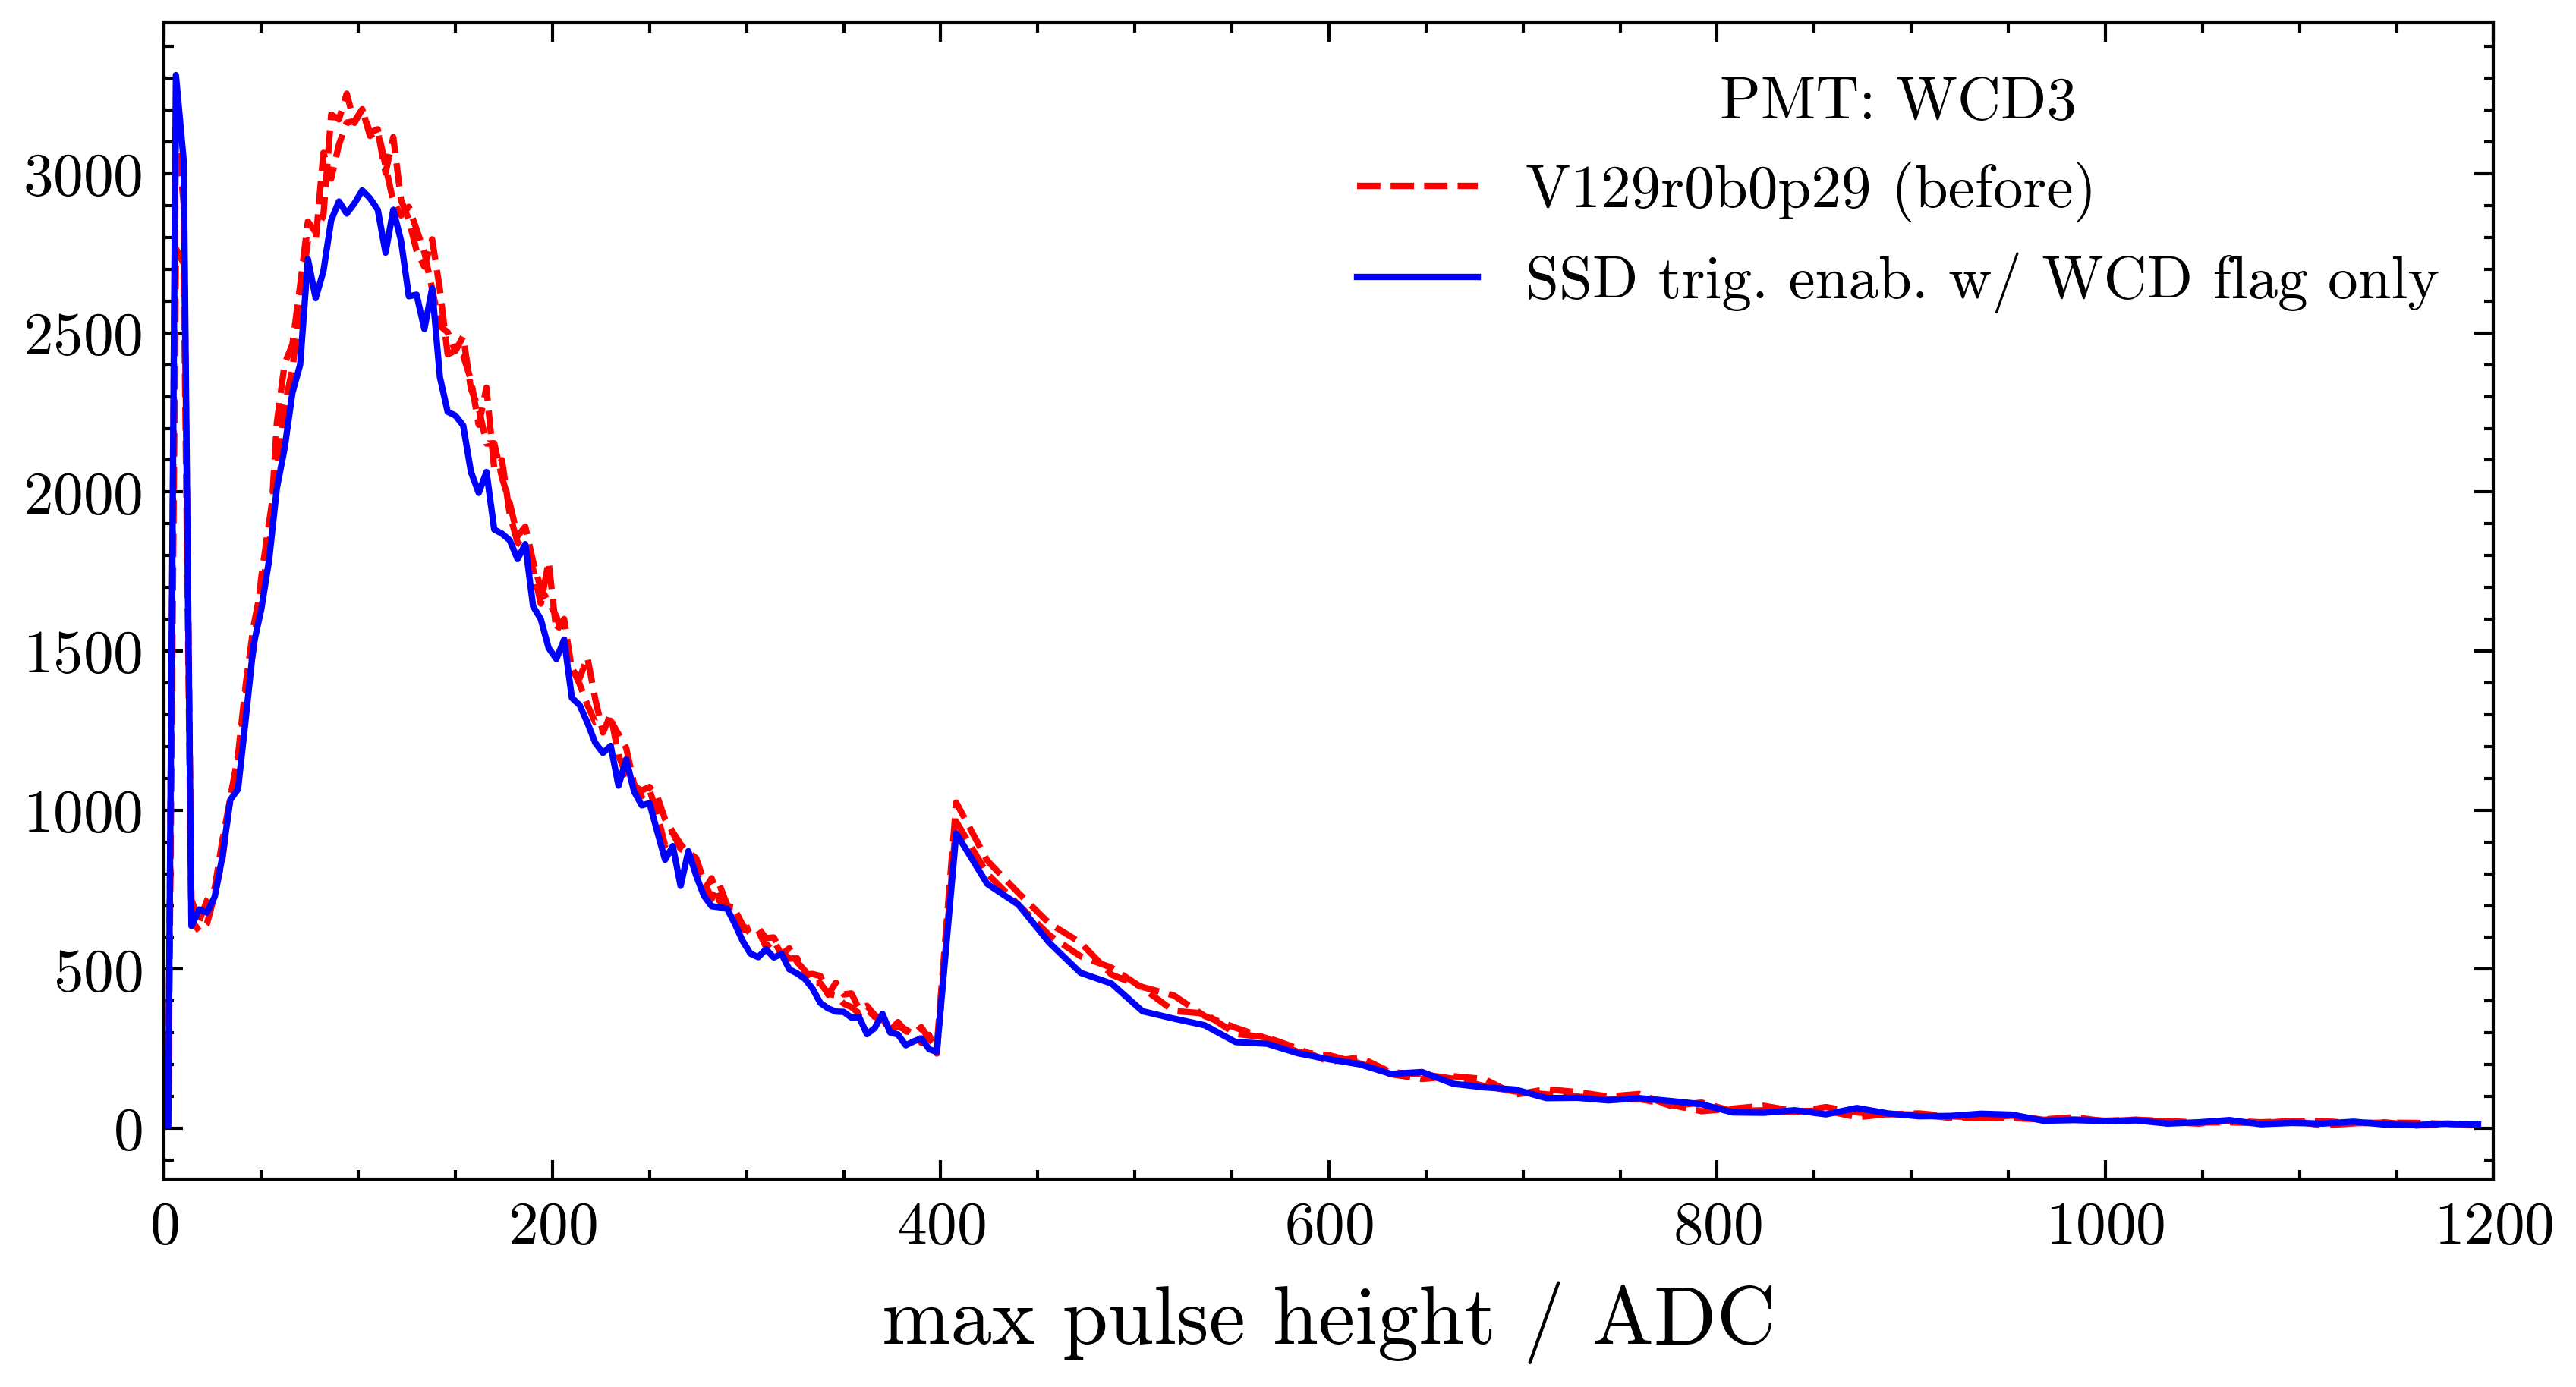

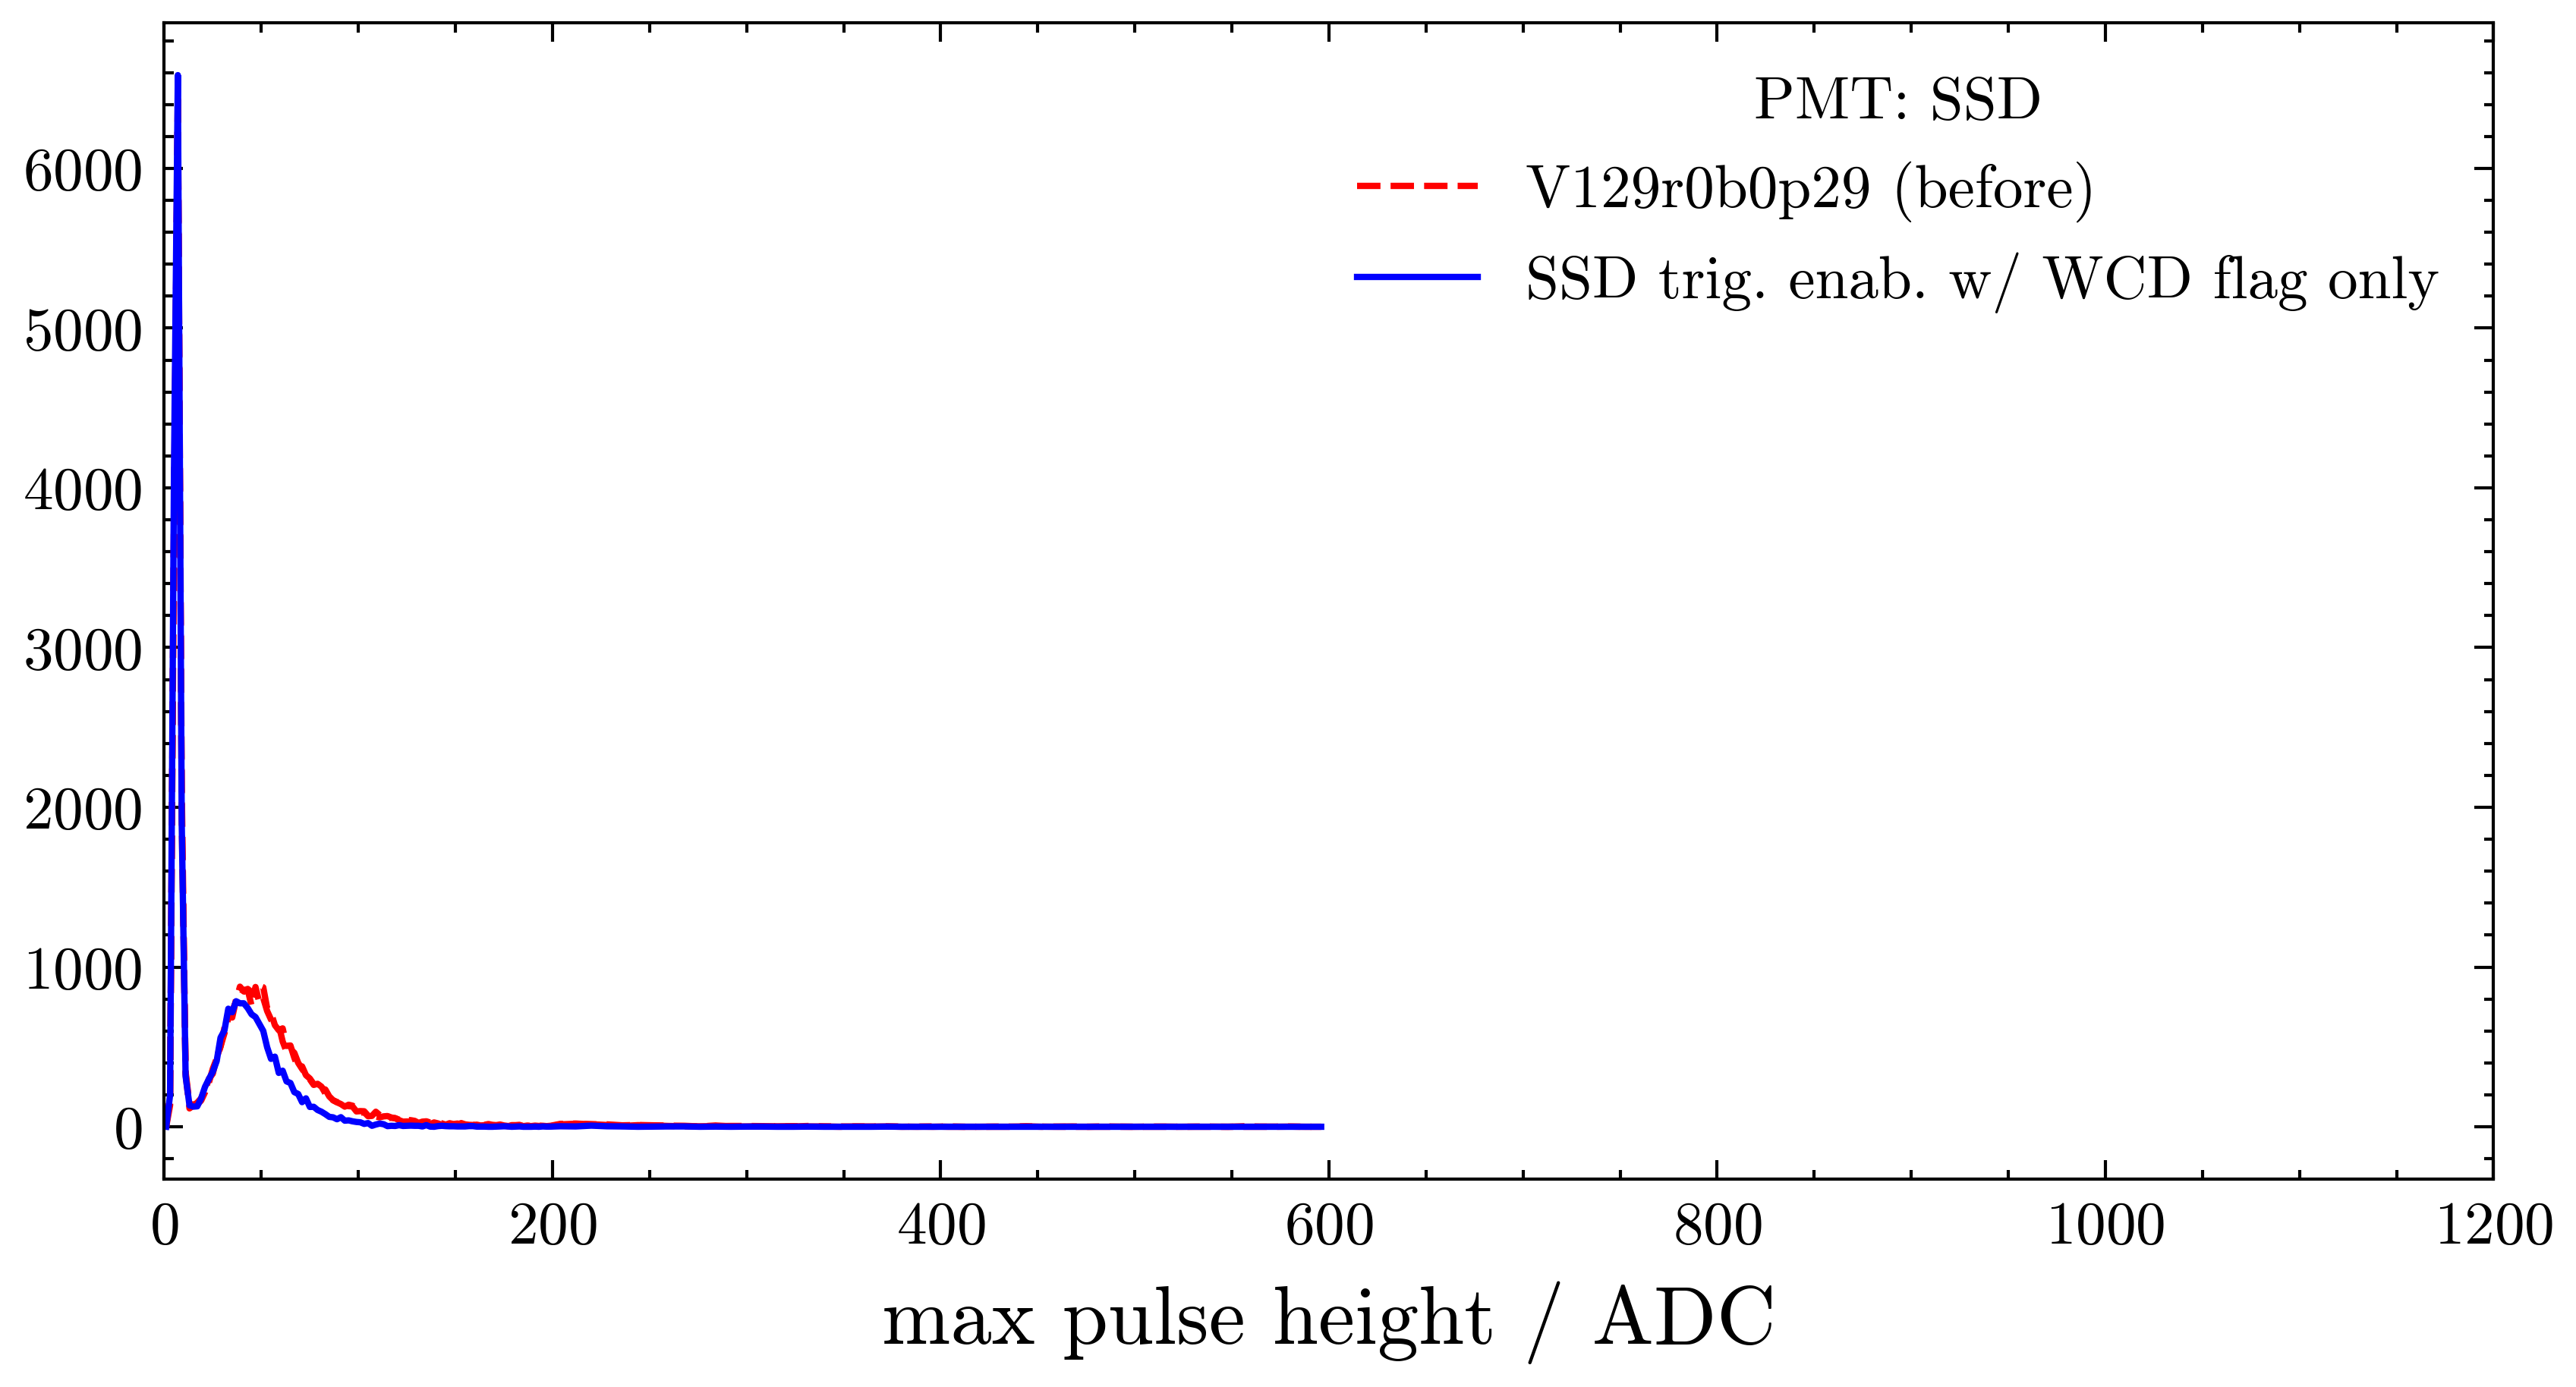

In [3]:
version = 'v31'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

# monit = Monit(*monit_files)
# t, wcd = monit('fTime', 136), monit('fPeak', 136).T
# vem = np.array([np.mean(w) for w in wcd] + [50])

t_acq = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', usecols=[0])
data = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/out.txt')
t_acq += CONSTANTS.GPS_OFFSET
data = data[:, 2:]

start, stop = np.min(t_acq), np.max(t_acq)

daq_start = {
    'v26' : 1727779746,
    'v27' : 1727786803,
    'v28' : 1727793640,
    'v29' : 1727797335,
    'v31' : 0,
}

mask_ref1 = np.where(np.logical_and(data[:, 0] < start, data[:, 0] > daq_start[version]))[0]
mask_acq = np.where(np.logical_and(data[:, 0] > start, data[:, 0] < stop))[0]
mask_ref2 = np.where(data[:, 0] > stop)[0]

axes = [plt.subplots()[1] for _ in range(4)]
titles = ['V129r0b0p29 (before)', 'SSD trig. enab. w/ WCD flag only']

for title, color, ls, mask in zip(titles, ['r', 'b', 'k'], ['--', 'solid', ':'], [mask_ref1, mask_acq, mask_ref2]):
    firsttime = True
        
    for histo in data[mask]:
        t, pmt, *histo = histo
        bins = CONSTANTS.UUB_SSD_BIN_CENTERS if pmt == 3 else CONSTANTS.UUB_WCD_BIN_CENTERS

        if firsttime:
            axes[int(pmt)].plot(bins, histo, c=color, ls=ls, label=title)
        else:
            axes[int(pmt)].plot(bins, histo, c=color, ls=ls)

        if pmt == 3: firsttime = False

title = ['WCD1', 'WCD2', 'WCD3', 'SSD']
for i in range(4):
    axes[i].legend(title=f"PMT: {title[i]}")
    axes[i].set_xlabel("max pulse height / ADC")
    axes[i].axvline(start, c='k', ls='--', lw=0.8)
    axes[i].axvline(stop, c='k', ls='--', lw=0.8)
    axes[i].set_xlim(0, 1200)
